<a href="https://colab.research.google.com/github/vargacypher/ClassificadorCancerPele/blob/master/Cance_Classific.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Introdução
O diagnóstico precoce das neoplasias cutâneas é uma das estratégias mais utilizadas para detectar lesões malignas em suas fases iniciais, possibilitando uma maior chance de tratamento. Na última década as ferramentas de bioinformática e ferramentas computacionais têm sido fundamentais para auxiliar no diagnóstico e na tomada de decisões, contribuindo para o diagnóstico complementar e elevando a probabilidade de um diagnóstico preciso. Desta forma o objetivo deste trabalho foi desenvolver um modelo capaz de classificar cânceres e lesões de pele, como uma ferramenta de auxílio diagnóstico, utilizando as imagens dermatoscópicas. Para o desenvolvimento do algoritmo, utilizamos imagens dermatoscópicas de **Nevos melanocíticos (nv),Melanoma (mel), Lesões tipo ceratose benigna (bkl), Carcinoma basocelular (bcc), Ceratoses actínicas (akiec), Lesões vasculares (vas) e Dermatofibroma (df),** da base de dados HAM10000. A rede neural foi desenvolvida na linguagem Python em conjunto com o framework TensorFlow. 



In [ ]:
import os
import plotly.express as px
import pandas as pd
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import layers
from tensorflow.keras import Model
from keras.models import Sequential
from tensorflow.keras.layers import Conv2D 
from tensorflow.keras.layers import MaxPooling2D 
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense

from tensorflow.keras.applications.inception_v3 import InceptionV3
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import RMSprop, Adam, SGD


#Avaliando o dataset

In [ ]:
df_base = pd.read_csv('/content/drive/MyDrive/SkinCancer/HAM10000_metadata.csv')
df_base.head()

lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear

#Distribuição das imagens 

In [ ]:
df_base.dx.value_counts()

nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: dx, dtype: int64

In [ ]:
df_base = df_base.rename(columns = {'dx':'label'})
df_base

lesion_id      image_id  label dx_type   age     sex localization
0      HAM_0000118  ISIC_0027419    bkl   histo  80.0    male        scalp
1      HAM_0000118  ISIC_0025030    bkl   histo  80.0    male        scalp
2      HAM_0002730  ISIC_0026769    bkl   histo  80.0    male        scalp
3      HAM_0002730  ISIC_0025661    bkl   histo  80.0    male        scalp
4      HAM_0001466  ISIC_0031633    bkl   histo  75.0    male          ear
...            ...           ...    ...     ...   ...     ...          ...
10010  HAM_0002867  ISIC_0033084  akiec   histo  40.0    male      abdomen
10011  HAM_0002867  ISIC_0033550  akiec   histo  40.0    male      abdomen
10012  HAM_0002867  ISIC_0033536  akiec   histo  40.0    male      abdomen
10013  HAM_0000239  ISIC_0032854  akiec   histo  80.0    male         face
10014  HAM_0003521  ISIC_0032258    mel   histo  70.0  female         back

[10015 rows x 7 columns]

In [ ]:
df_base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   label         10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
dtypes: float64(1), object(6)
memory usage: 547.8+ KB


In [ ]:
canceres = df_base.label.value_counts()
canceres

nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: label, dtype: int64

In [ ]:
import plotly.express as px

fig = px.bar(x = canceres.index, y = canceres,labels=dict(x="Câncer ou Lesão", y="Contagem"))

fig.show()

In [ ]:
sex = df_base.sex.value_counts()
sex

male       5406
female     4552
unknown      57
Name: sex, dtype: int64

In [ ]:
fig = px.bar(x = sex.index, y = sex,labels=dict(x="Sexo", y="Contagem"))
fig.show()

In [ ]:
age_sex = df_base[['age','sex']]
age_sex = age_sex.value_counts().to_frame().reset_index()
age_sex = age_sex.rename(columns = {0:'count'})
age_sex

In [ ]:
fig = px.scatter(age_sex, x="age", y="count", color="sex",labels=dict(x="Idade", y="Contagem"))
fig.show()

#Localização das lesões

In [ ]:
local = df_base[['localization','label']]
local = local.value_counts().to_frame().reset_index()
local = local.rename(columns={0:'Qntd'})
local

localization  label  Qntd
0   lower extremity     nv  1479
1              back     nv  1427
2             trunk     nv  1241
3           abdomen     nv   860
4   upper extremity     nv   655
..              ...    ...   ...
76             hand    bcc     2
77             foot    bkl     1
78          genital     df     1
79             hand    mel     1
80            trunk  akiec     1

[81 rows x 3 columns]

In [ ]:
fig = px.bar(local, y='Qntd',x='label',color='localization')
fig.show()

#Carregando dataset com pixeis 28x28 de cada imagem

In [ ]:
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler 
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import os, cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from sklearn.metrics import confusion_matrix , classification_report
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from PIL import Image
# Import some modules
from keras.layers import Conv2D, MaxPooling2D, Input, BatchNormalization, ReLU
from keras.models import Sequential
from keras.layers.core import Flatten, Activation, Dense, Dropout
from keras.layers.core import ActivityRegularization
from keras.layers.advanced_activations import LeakyReLU


df_rgb = pd.read_csv('/content/drive/MyDrive/SkinCancer/hmnist_28_28_RGB.csv')

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning:

The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning:

The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.



In [ ]:
df_rgb.head()

pixel0000  pixel0001  pixel0002  ...  pixel2350  pixel2351  label
0        192        153        193  ...        154        177      2
1         25         14         30  ...         14         27      2
2        192        138        153  ...        104        117      2
3         38         19         30  ...         12         15      2
4        158        113        139  ...         78         92      2

[5 rows x 2353 columns]

In [ ]:
labels = df_rgb.label.value_counts()
labels

4    6705
6    1113
2    1099
1     514
0     327
5     142
3     115
Name: label, dtype: int64

In [ ]:
import plotly.express as px

px.bar(x=labels.index, y=labels, labels=dict(x='Cânceres/Lesões',y='Contagem'))

#Separação dos labels e as features

In [ ]:
y = df_rgb['label']
x = df_rgb.drop(columns = ['label'])

print( f'X_Shape:{x.shape}')
print( f'Y_Shape:{y.shape}')

X_Shape:(10015, 2352)
Y_Shape:(10015,)


#SPLIT DATA

Divisão dos dados para treino e teste do modelo

**Treino e teste**

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = 0.20)

#OVERSAMPLING

Técnica para aumento de dados sem agumentation

In [ ]:
oversample = RandomOverSampler()
x_train,y_train = oversample.fit_resample(x_train,y_train)

#Reshape para a camada de entrada
x_train = np.array(x_train).reshape(-1,28,28,3) 
x_test = np.array(x_test).reshape(-1,28,28,3) 

print('Shape of Data :',x_train.shape)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.



Shape of Data : (37471, 28, 28, 3)


#Standardization 

Optamos por normalizar dividindo a média pelo desvio padrão
dos dados, resultando em valores de recursos de alcance semelhante, facilitando com que o modelo aprenda as características das imagens. 


Nós podemos fazer uma **Normalização** dividindo os pixels por 255 e escalar entre 0 e 1 tbm

In [ ]:
teste = [[222,222],
         [122,255]]
teste = (teste-np.mean(teste))/np.std(teste)
teste

array([[ 0.33555833,  0.33555833],
       [-1.66777498,  0.99665832]])

In [ ]:
x_train = (x_train-np.mean(x_train))/np.std(x_train)
x_test = (x_test-np.mean(x_test))/np.std(x_test)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



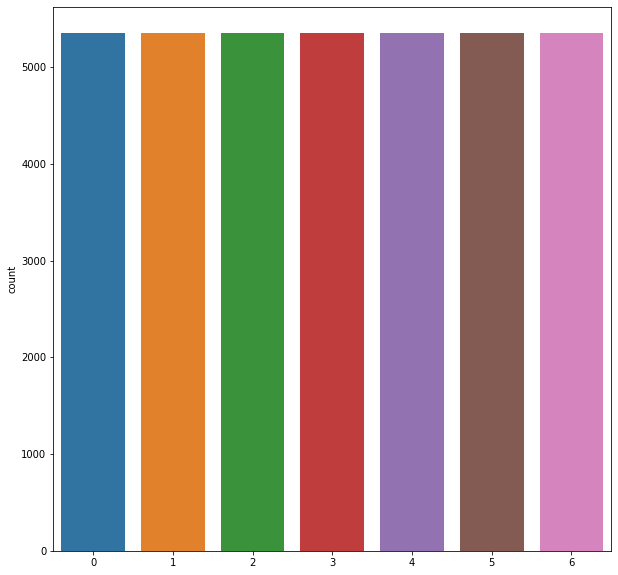

In [ ]:
plt.figure(figsize = (10,10))
sns.countplot(y_train)

**SEM STANDERIZATION**



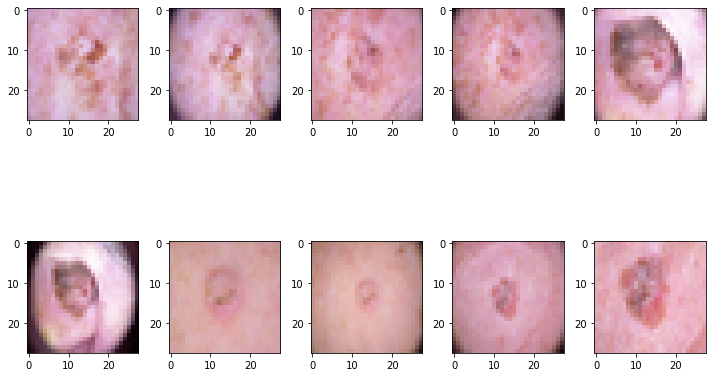

In [ ]:
f , ax = plt.subplots(2,5)
f.set_size_inches(10, 10)
k = 0 
for i in range(2):
    for j in range(5):
        ax[i,j].imshow(x[k].reshape(28,28,3))
        k = k + 1
    plt.tight_layout()

**COM STANDERIZATION**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

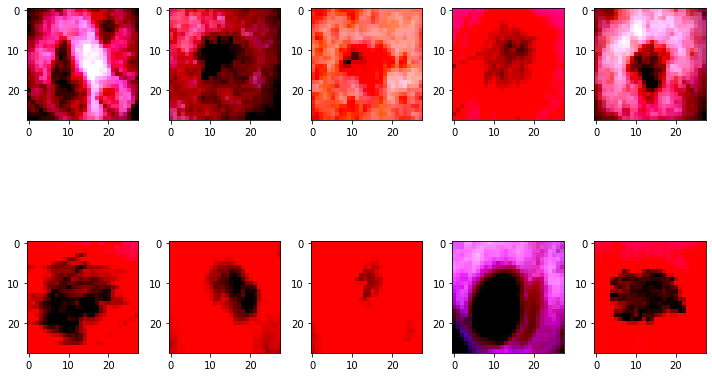

In [ ]:
f , ax = plt.subplots(2,5)
f.set_size_inches(10, 10)
k = 0 
for i in range(2):
    for j in range(5):
        ax[i,j].imshow(x_train[k].reshape(28,28,3))
        k = k + 1
    plt.tight_layout()

#MODELOS

Foram criados dois modelos diferentes de CNN para avalair seu desempenho.

In [ ]:
model = Sequential()
model.add(Conv2D(16, kernel_size = (3,3), input_shape = (28, 28, 3), activation = 'relu', padding = 'same'))
model.add(Conv2D(32, kernel_size = (3,3), activation = 'relu'))
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Conv2D(32, kernel_size = (3,3), activation = 'relu', padding = 'same'))
model.add(Conv2D(64, kernel_size = (3,3), activation = 'relu'))
model.add(MaxPool2D(pool_size = (2,2), padding = 'same'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(7, activation='softmax'))
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 16)        448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 32)        4640      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 2304)              0

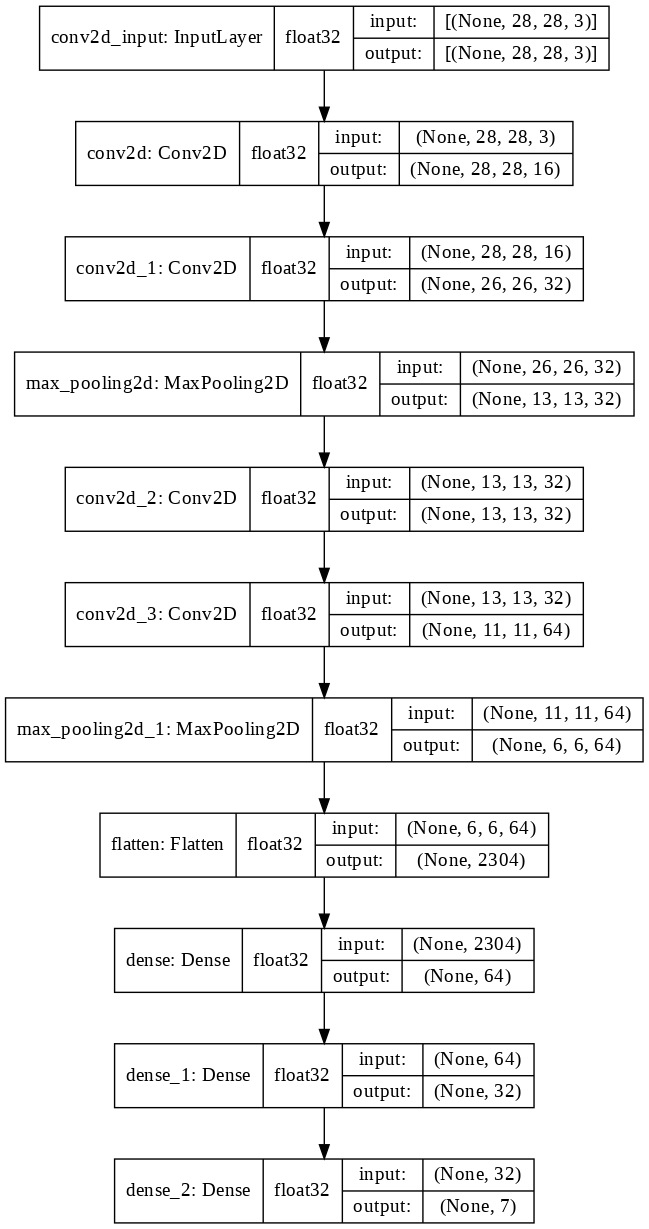

In [ ]:
tf.keras.utils.plot_model(model, show_shapes = True, show_dtype = True, show_layer_names = True, rankdir="TB", expand_nested = True, dpi = 100) # ,to_file='model.png')

#COMPILE

In [ ]:
model.compile(loss = 'sparse_categorical_crossentropy',
             optimizer = 'adam',
              metrics = ['accuracy'])

history = model.fit(x_train,
                    y_train,
                    validation_split=0.2,
                    batch_size = 128,
                    epochs = 50,
                     shuffle= True)

Epoch 1/50
235/235 [==============================] - 35s 16ms/step - loss: 1.1770 - accuracy: 0.5582 - val_loss: 1.6374 - val_accuracy: 0.3755
Epoch 2/50
235/235 [==============================] - 3s 13ms/step - loss: 0.5687 - accuracy: 0.8101 - val_loss: 1.6711 - val_accuracy: 0.4184
Epoch 3/50
235/235 [==============================] - 3s 13ms/step - loss: 0.3406 - accuracy: 0.8871 - val_loss: 1.0216 - val_accuracy: 0.5554
Epoch 4/50
235/235 [==============================] - 3s 14ms/step - loss: 0.2308 - accuracy: 0.9230 - val_loss: 0.8399 - val_accuracy: 0.5895
Epoch 5/50
235/235 [==============================] - 3s 13ms/step - loss: 0.1816 - accuracy: 0.9363 - val_loss: 1.1266 - val_accuracy: 0.5437
Epoch 6/50
235/235 [==============================] - 3s 14ms/step - loss: 0.1582 - accuracy: 0.9461 - val_loss: 0.6317 - val_accuracy: 0.7388
Epoch 7/50
235/235 [==============================] - 3s 14ms/step - loss: 0.1331 - accuracy: 0.9545 - val_loss: 0.6543 - val_accuracy: 0.700

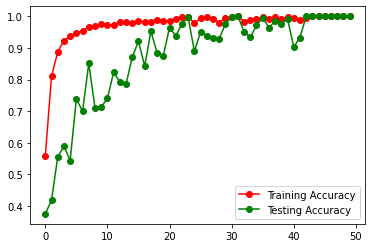

In [ ]:
plt.plot(history.history["accuracy"] , 'ro-' , label = "Training Accuracy")
plt.plot(history.history["val_accuracy"] , 'go-' , label = "Testing Accuracy")
plt.legend()
plt.show()

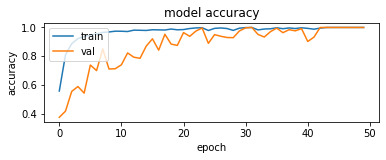

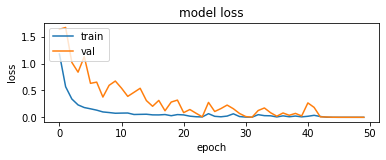

In [ ]:
# plt.figure(figsize= (5, 5))
plt.subplot(211)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.subplot(212)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#TESTE

In [ ]:
loss, acc = model.evaluate(x_test, y_test, verbose=2)

63/63 - 0s - loss: 2.8124 - accuracy: 0.7479


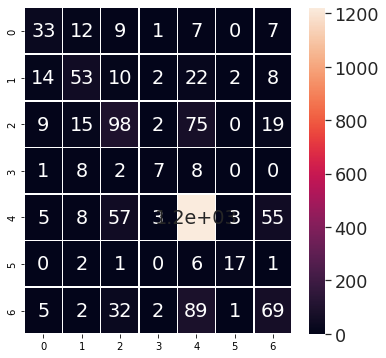

In [ ]:
# Prediction on test data
y_pred = model.predict(x_test)
# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred, axis = 1) 
# Convert test data to one hot vectors
y_true = y_test

#Print confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

fig, ax = plt.subplots(figsize=(6,6))
sns.set(font_scale=1.6)
sns.heatmap(cm, annot=True, linewidths=.5, ax=ax)


Text(0, 0.5, 'Fraction of incorrect predictions')

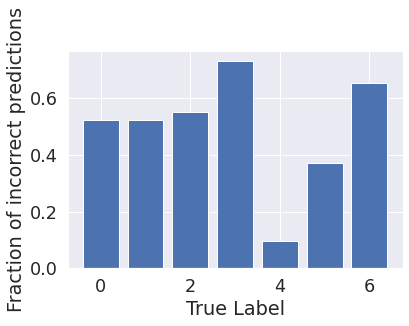

In [ ]:
#PLot fractional incorrect misclassifications
incorr_fraction = 1 - np.diag(cm) / np.sum(cm, axis=1)
plt.bar(np.arange(7), incorr_fraction)
plt.xlabel('True Label')
plt.ylabel('Fraction of incorrect predictions')


#Modelo 2


**MODELO**

In [ ]:
model= Sequential()
model.add(Conv2D(256, 3, input_shape = (28, 28, 3), activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, 3, activation= 'relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(64, 3, activation= 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(64, activation= 'relu'))
model.add(Dense(32, activation= 'relu'))
model.add(Dense(7, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 26, 26, 256)       7168      
_________________________________________________________________
batch_normalization (BatchNo (None, 26, 26, 256)       1024      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 256)       0         
_________________________________________________________________
dropout (Dropout)            (None, 13, 13, 256)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 11, 11, 128)       295040    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 5, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 5, 128)        

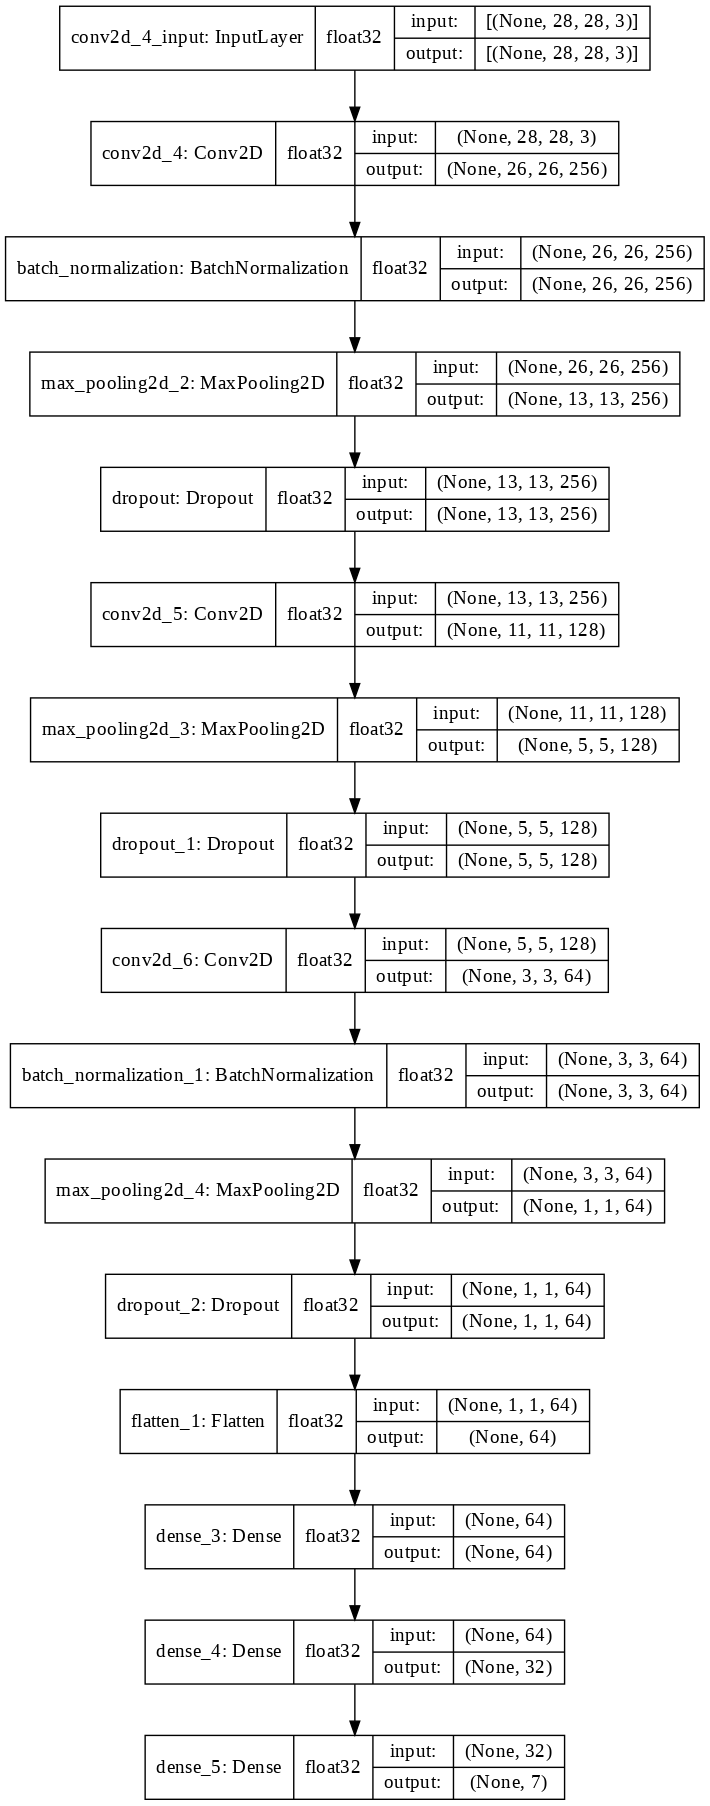

In [ ]:
tf.keras.utils.plot_model(model, show_shapes = True, show_dtype = True, show_layer_names = True, rankdir="TB", expand_nested = True, dpi = 100) # ,to_file='model.png')

#COMPILE

In [ ]:
model.compile(loss = 'sparse_categorical_crossentropy',
             optimizer = 'adam',
              metrics = ['accuracy'])
history = model.fit(x_train,
                    y_train,
                    validation_split=0.2, #20% de dados para validação do modelo durante o treino
                    batch_size = 128,
                    epochs = 75,
                     shuffle= True)

Epoch 1/75
235/235 [==============================] - 10s 38ms/step - loss: 1.3255 - accuracy: 0.5019 - val_loss: 3.2019 - val_accuracy: 0.0266
Epoch 2/75
235/235 [==============================] - 8s 36ms/step - loss: 0.8330 - accuracy: 0.6971 - val_loss: 2.0344 - val_accuracy: 0.3241
Epoch 3/75
235/235 [==============================] - 8s 36ms/step - loss: 0.6408 - accuracy: 0.7686 - val_loss: 1.7304 - val_accuracy: 0.3841
Epoch 4/75
235/235 [==============================] - 9s 36ms/step - loss: 0.5233 - accuracy: 0.8119 - val_loss: 1.4397 - val_accuracy: 0.4260
Epoch 5/75
235/235 [==============================] - 8s 36ms/step - loss: 0.4404 - accuracy: 0.8424 - val_loss: 1.5451 - val_accuracy: 0.3897
Epoch 6/75
235/235 [==============================] - 8s 36ms/step - loss: 0.3836 - accuracy: 0.8630 - val_loss: 1.1469 - val_accuracy: 0.5508
Epoch 7/75
235/235 [==============================] - 8s 36ms/step - loss: 0.3388 - accuracy: 0.8792 - val_loss: 1.1405 - val_accuracy: 0.512

In [ ]:
loss, acc = model.evaluate(x_test, y_test, verbose=2)

63/63 - 1s - loss: 1.0298 - accuracy: 0.7464


In [ ]:
model.save('/content/drive/My Drive/SkinCancer/model.h5')

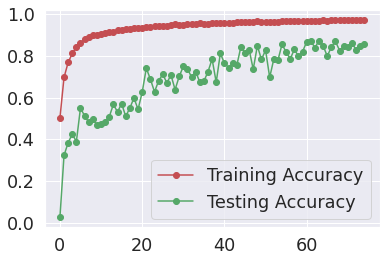

In [ ]:
plt.plot(history.history["accuracy"] , 'ro-' , label = "Training Accuracy")
plt.plot(history.history["val_accuracy"] , 'go-' , label = "Testing Accuracy")
plt.legend()
plt.show()

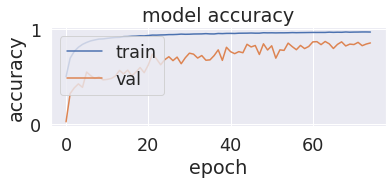

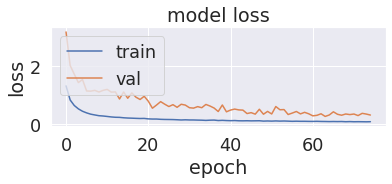

In [ ]:
# plt.figure(figsize= (5, 5))
plt.subplot(211)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.subplot(212)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Durante o treinamento foi possível observar 97% de acurácia e erro (loss) de 0.078, já  nos dados de validação 85% de acurácia e erro de 0.308. Ao final com os dados de teste que o modelo nunca tinha visto antes obtivemos um erro de 1.029 e acurácia de  74%.
    O modelo aparentemente se ajustou bem aos dados de treinamento, porém podendo indicar um certo overfitting em decorrência do aumento dos dados sem tantas transformações nas imagens. Acurácia elevada quando comparado com os dados de teste pode ter se dado ao fato de termos uma maior variabilidade de alguns tipos de cânceres e lesões em nossos dados, a outros pequenos ajustes que podem ser necessários realizar na arquitetura e/ou nos otimizadores do modelo.


In [ ]:
labels_dict = {4: 'Nevo melanocítico',
    6: 'Melanoma',
    2: 'Ceratose Seborreica ',
    1: 'Carcinoma basocelular',
    0: 'Ceratose actínica',
    5: 'Lesões vasculares',
    3: 'Dermatofibroma'}

labels_dict2 = {4: 'Nv',
    6: 'Mel',
    2: 'Bkl',
    1: 'Bcc',
    0: 'Akiec',
    5: 'Vasc',
    3: 'Df'}

In [ ]:
cm_plots = ['Akiec','Bcc',
            'Bkl','Df','Nv',
            'Vasc','Mel']

In [ ]:
import itertools

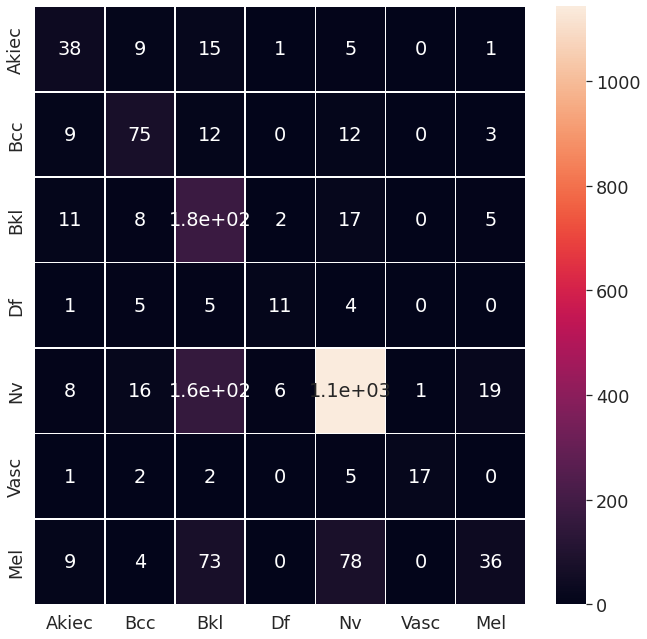

In [ ]:
# Prediction on test data
y_pred = model.predict(x_test)
# argmax returns the index of the max value in a row
y_pred_classes = np.argmax(y_pred, axis = 1) 
y_true =  y_test

#Print confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

fig, ax = plt.subplots(figsize=(11,11))
sns.set(font_scale=1.6)
sns.heatmap(cm, xticklabels=cm_plots, yticklabels=cm_plots, annot=True, linewidths=.5, ax=ax)


In [ ]:
from sklearn.metrics import classification_report

#Convertendo para one-hot encode
y_true = to_categorical (y_test)

# Generate a classification report
report = classification_report(y_true, y_pred.round(), target_names=cm_plots)

print(report)



              precision    recall  f1-score   support

       Akiec       0.51      0.54      0.52        69
         Bcc       0.64      0.67      0.65       111
         Bkl       0.40      0.78      0.53       218
          Df       0.55      0.42      0.48        26
          Nv       0.91      0.84      0.87      1352
        Vasc       0.94      0.56      0.70        27
         Mel       0.60      0.16      0.25       200

   micro avg       0.76      0.74      0.75      2003
   macro avg       0.65      0.57      0.57      2003
weighted avg       0.79      0.74      0.74      2003
 samples avg       0.74      0.74      0.74      2003



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.



A matriz de confusão representa uma tabela de frequências de classificação para cada classe do modelo, trazendo um comparativo entre os valores que o modelo predisse em relação aos valores reais ocorridos. Ela pode ser representada  pela forma geral de classificação binária :


Através da matriz de confusão podemos calcular métricas importantes como precisão, f1-score e sensibilidade do modelo. A precision (precisão) representa às imagens classificadas corretamente, em relação a todas as imagens na classe positiva, sendo representada pela equação ( 𝑉 𝑃/𝑉 𝑃 + 𝑉 𝑁 ). O recall demonstra o quão eficiente é o modelo para cada tipo de lesão, também é conhecido como taxa de verdadeiros positivos, demonstrando efetividade do sistema na classificação dos rótulos positivos.  O f1-score combina o recall com a precisão e frequentemente é uma métrica melhor que a acurácia pois leva em consideração o impacto dos FP e FN no modelo (GOODFELLOW et al., 2016 ).


Obviamente o modelo apresentou um ótimo desempenho na classificação de NV, isso pode se dar pelo fato da alta variabilidade de imagens disponíveis para este tipo de lesão. A classificação de lesões BCC e VASC também apresentaram precision e f1-score com valores consideráveis mesmo com um número de amostras baixas no caso de lesões VASC.


Poderíamos melhorar a questão do certo overfitting que temos em nosso modelo e a baixa quantidade de amostras em alguns tipos de câncer e lesões utilizando técnicas de data agumentation nas imagens, trabalhando com rotações, outras escalas de cores e filtros como apresentado pelos autores ( MINANGO et al, 2020; VANHEULE; PIžURICA, 2018). Alguns testes foram realizados brevemente porém aparentemente não surtiu muito efeito na acurácia do modelo.


#VISUALIZANDO CAMADAS


conv2d_71_input (1, 28, 28, 3) 


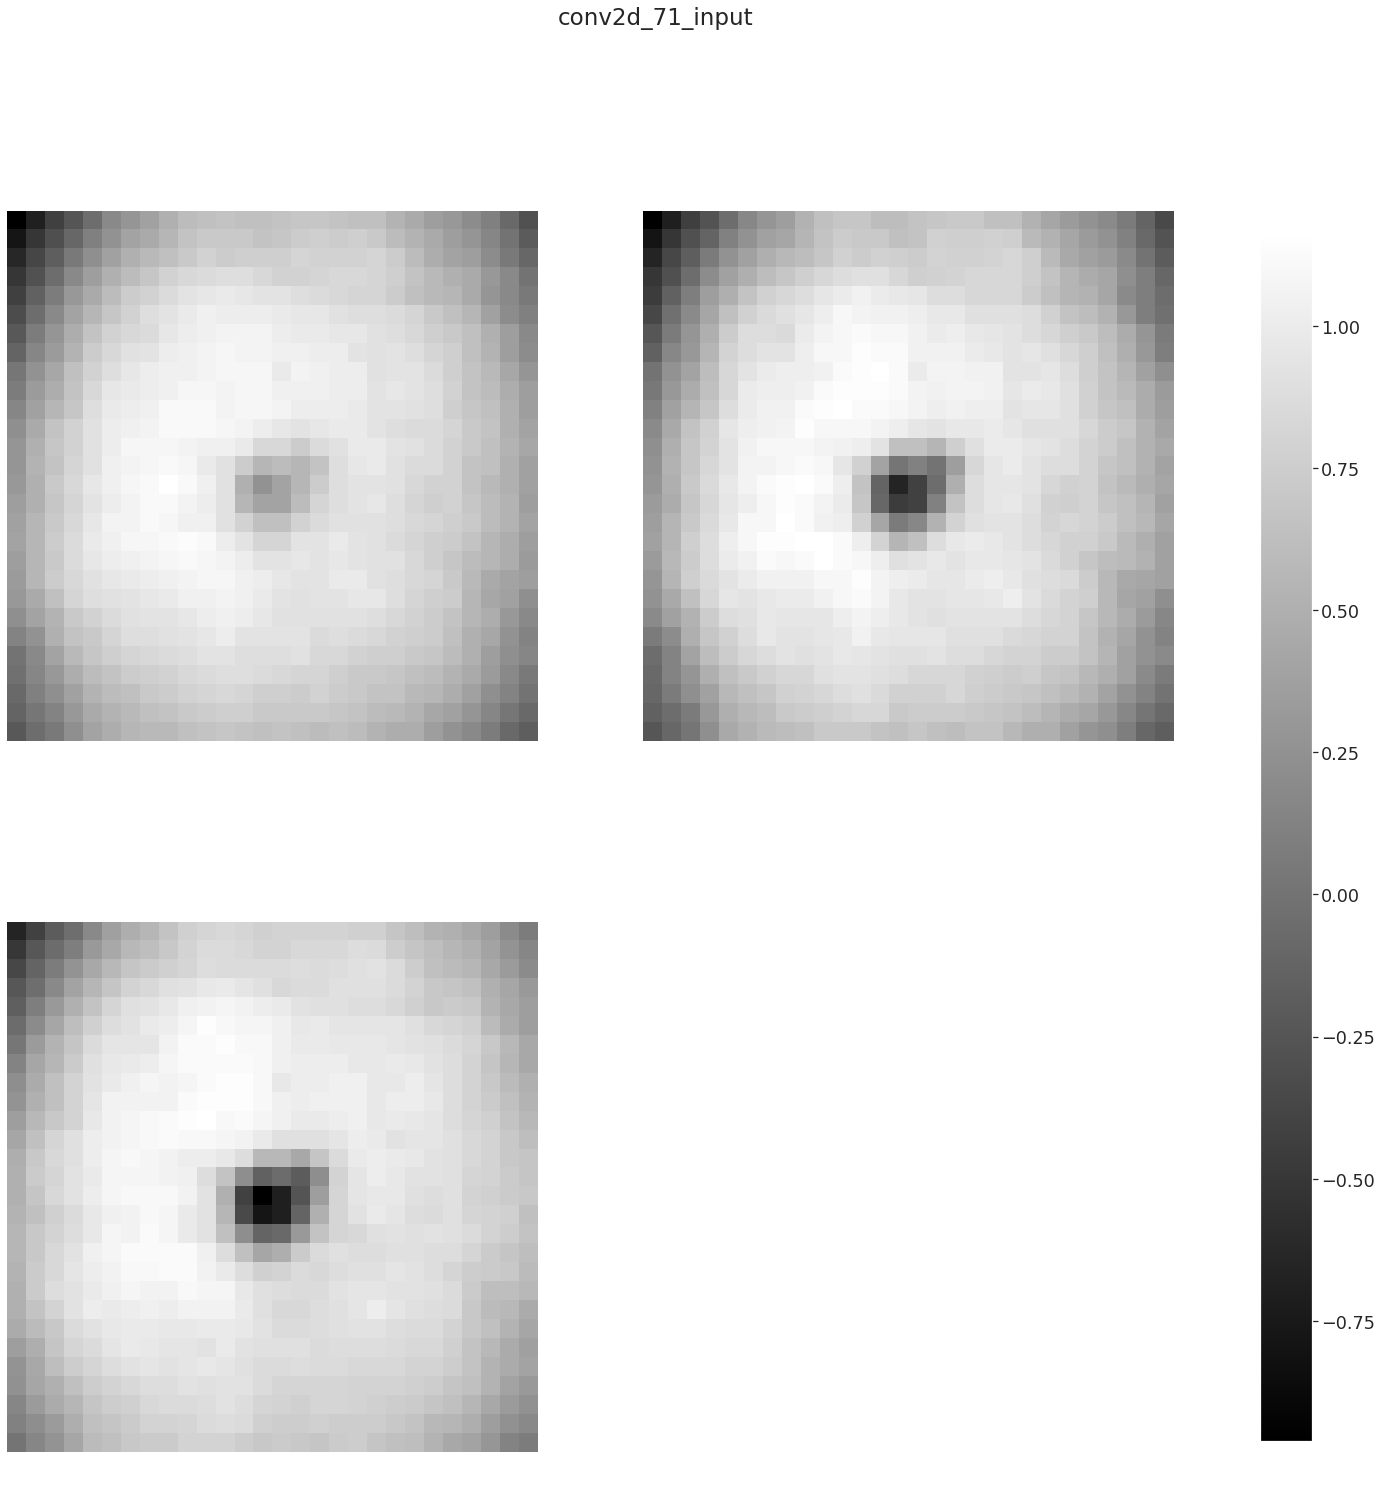

conv2d_71 (1, 26, 26, 256) 


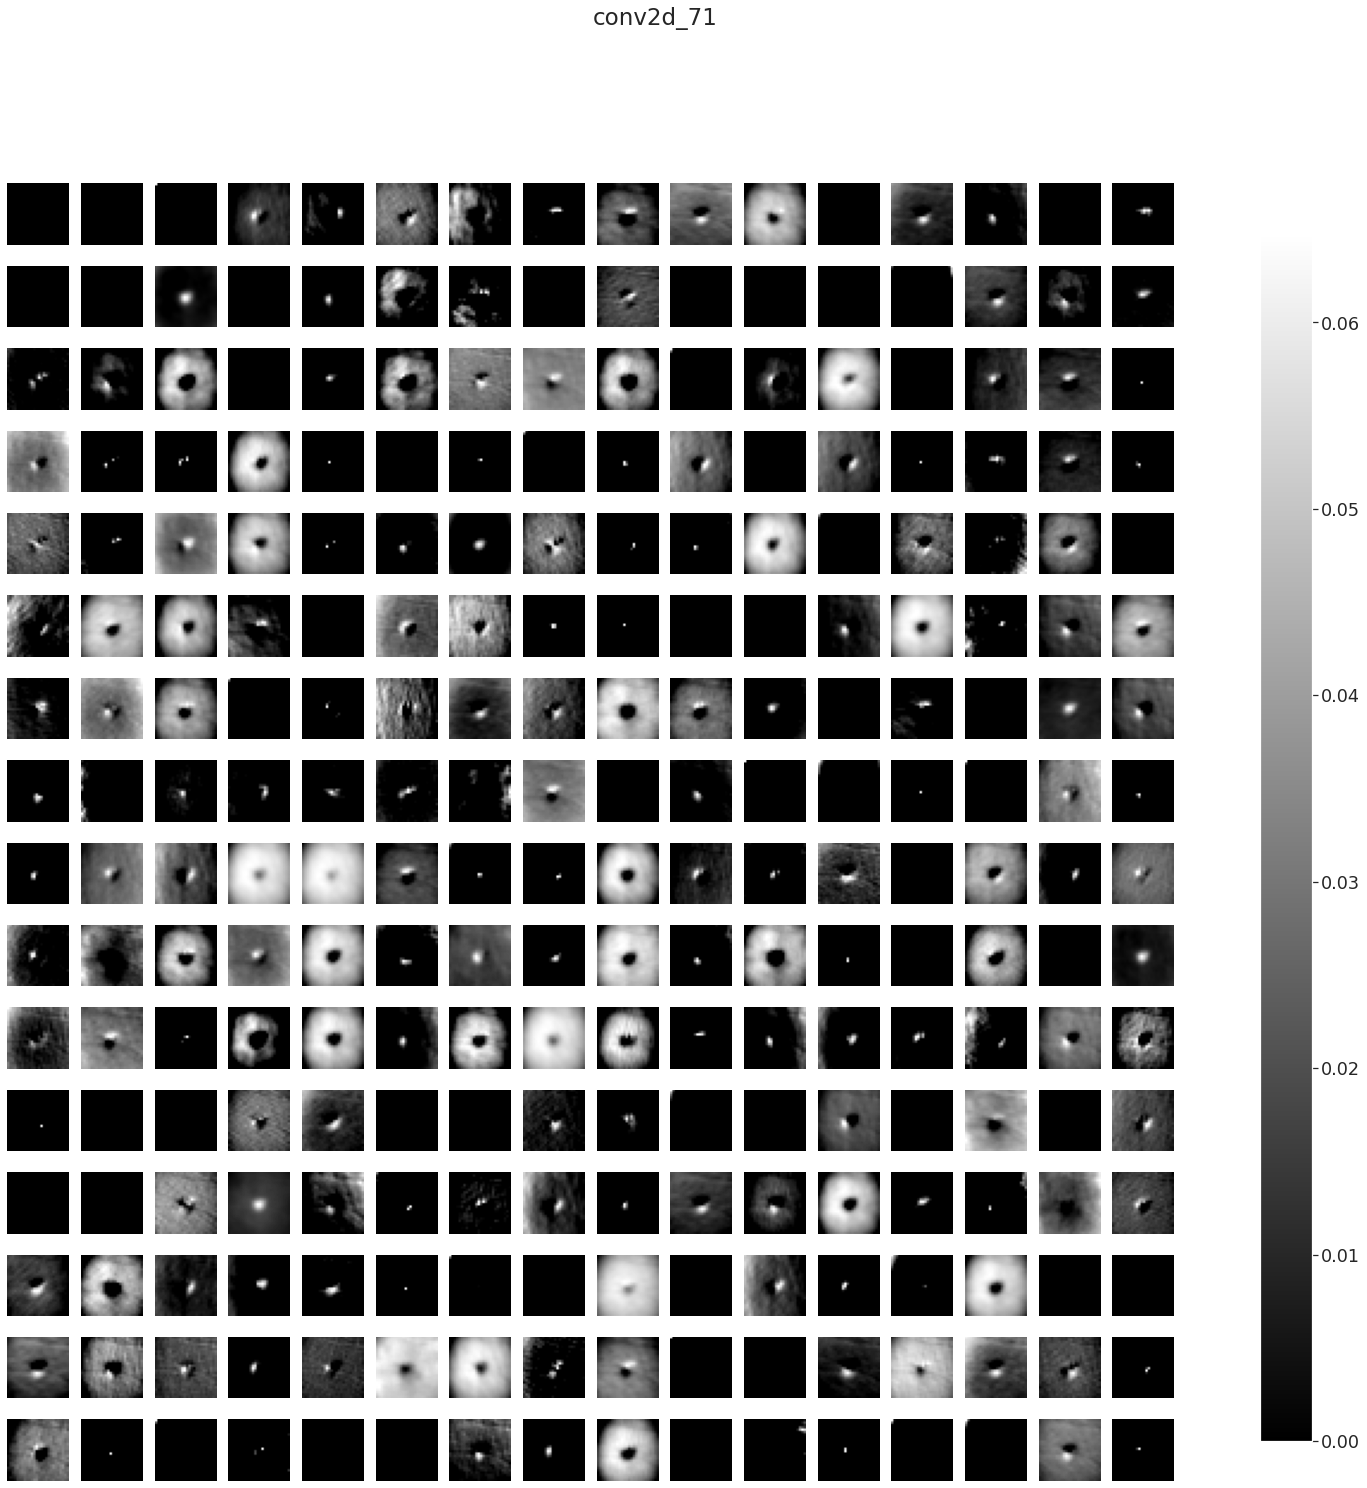

batch_normalization_16 (1, 26, 26, 256) 


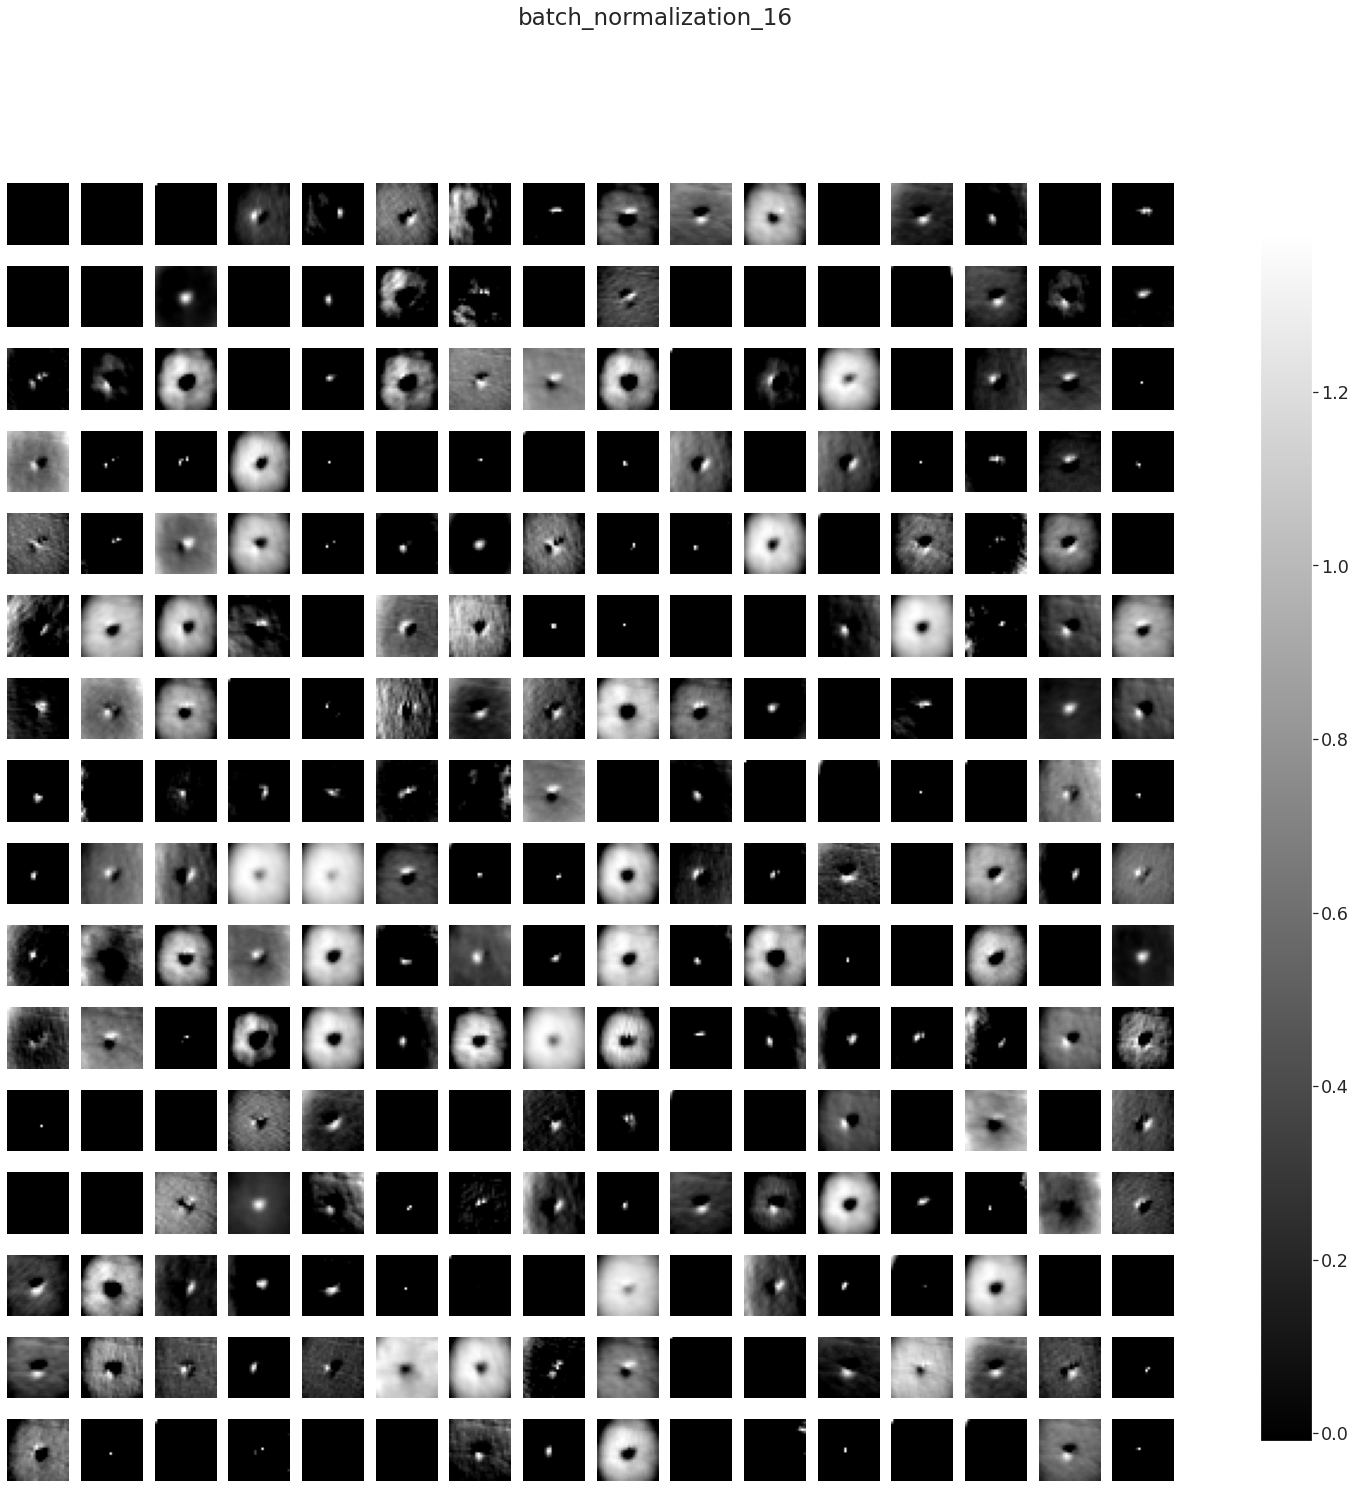

max_pooling2d_38 (1, 13, 13, 256) 


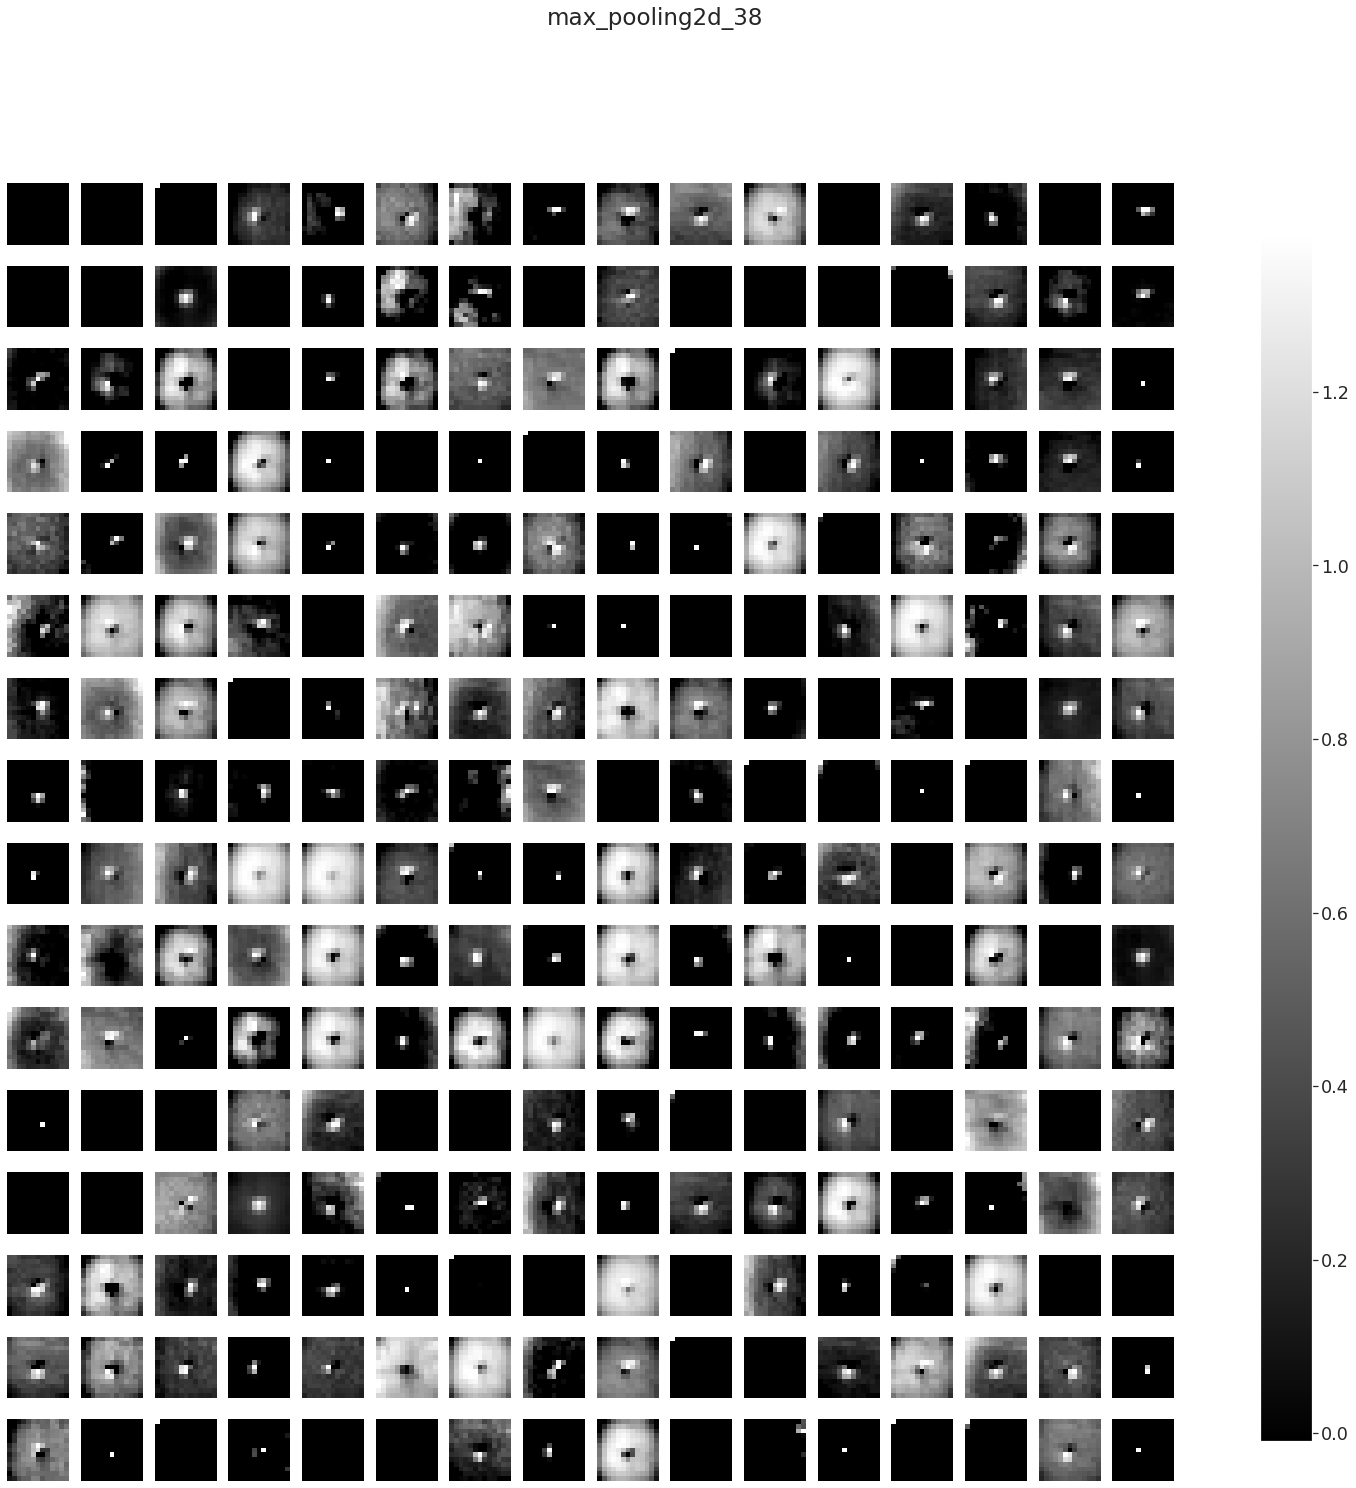

dropout_38 (1, 13, 13, 256) 


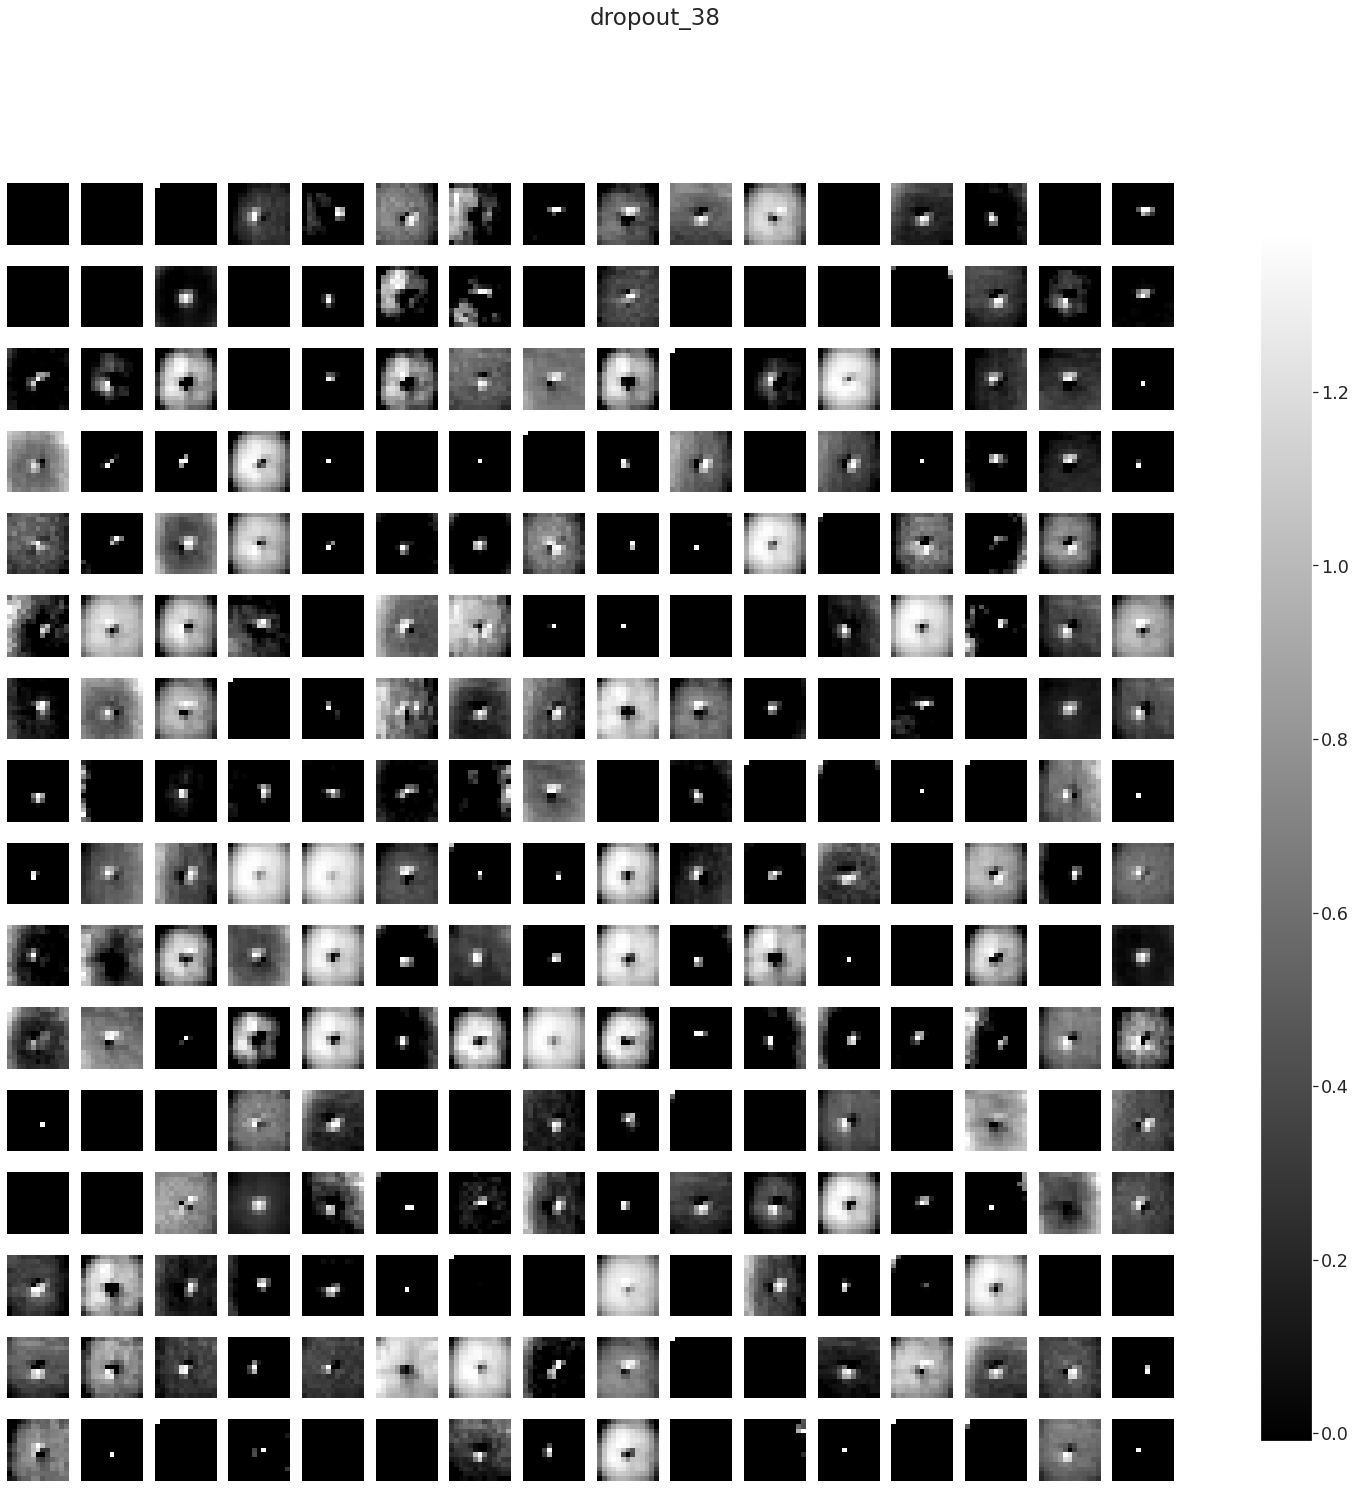

conv2d_72 (1, 11, 11, 128) 


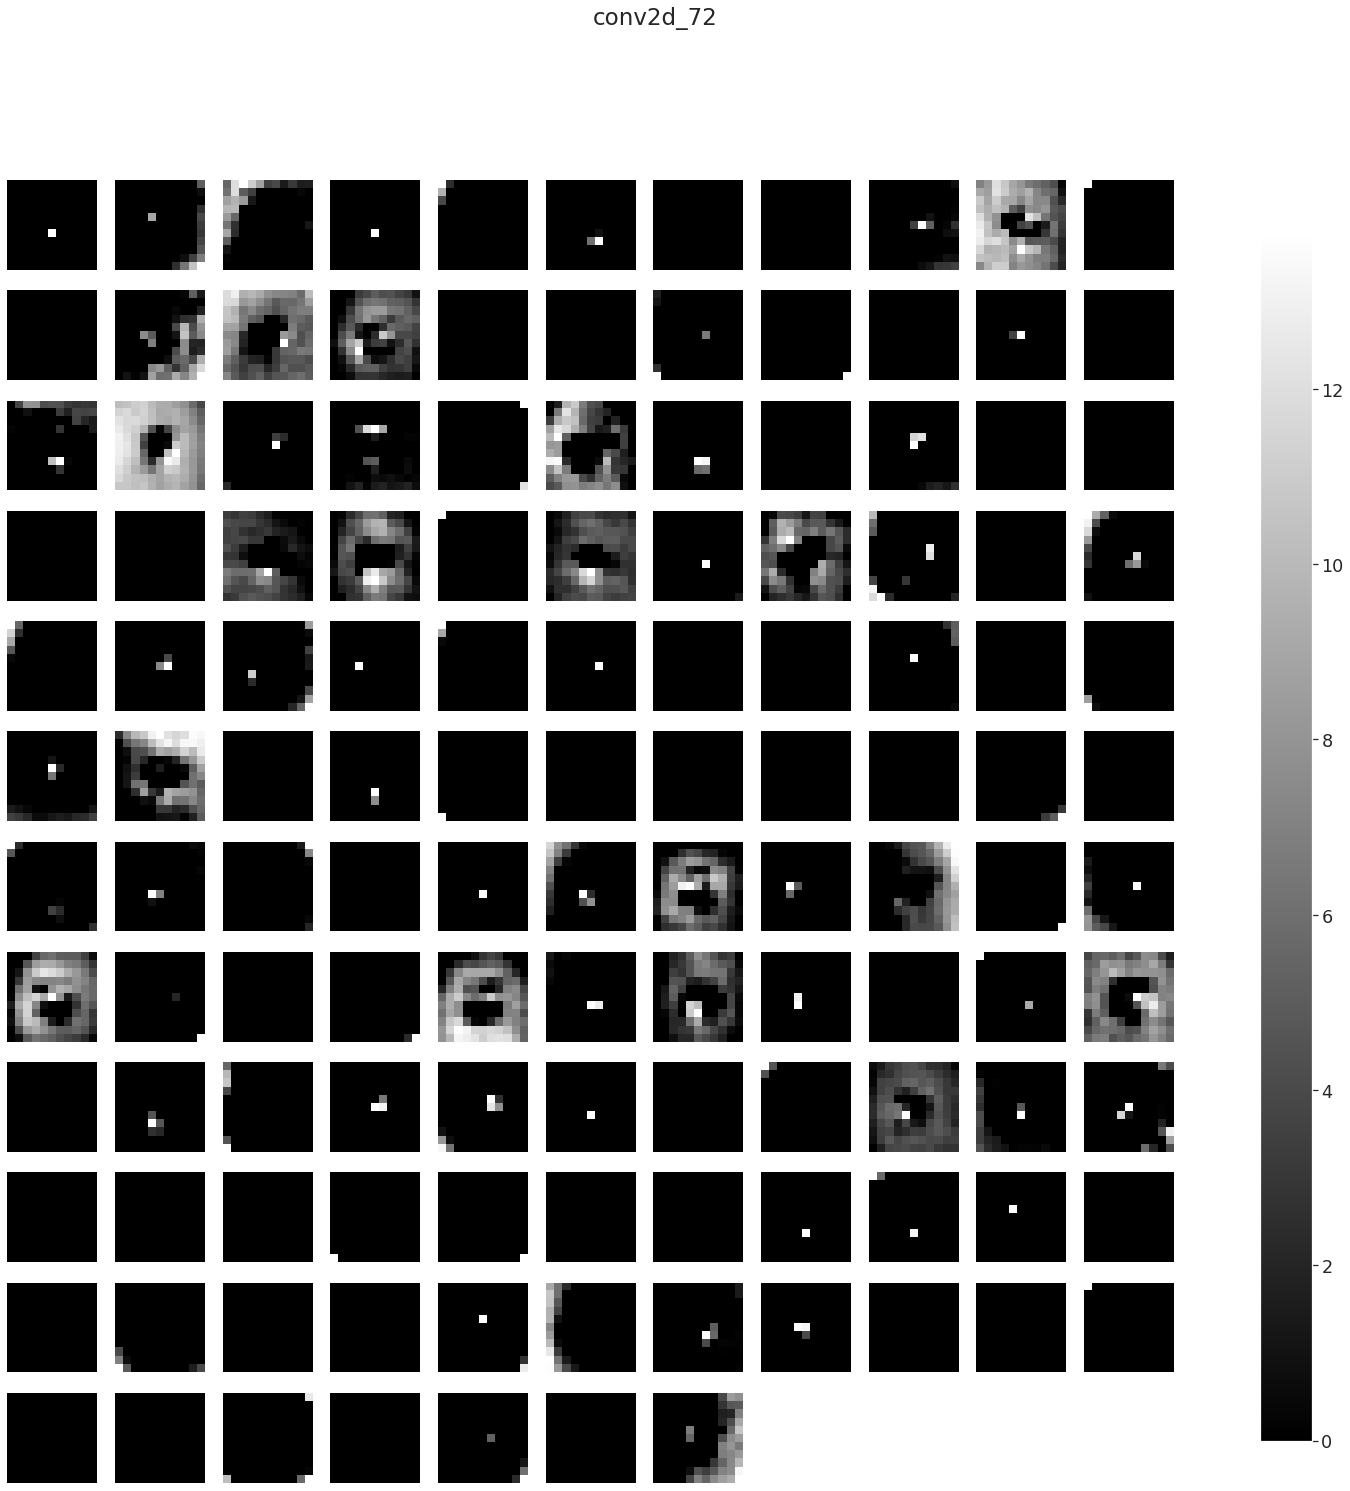

max_pooling2d_39 (1, 5, 5, 128) 


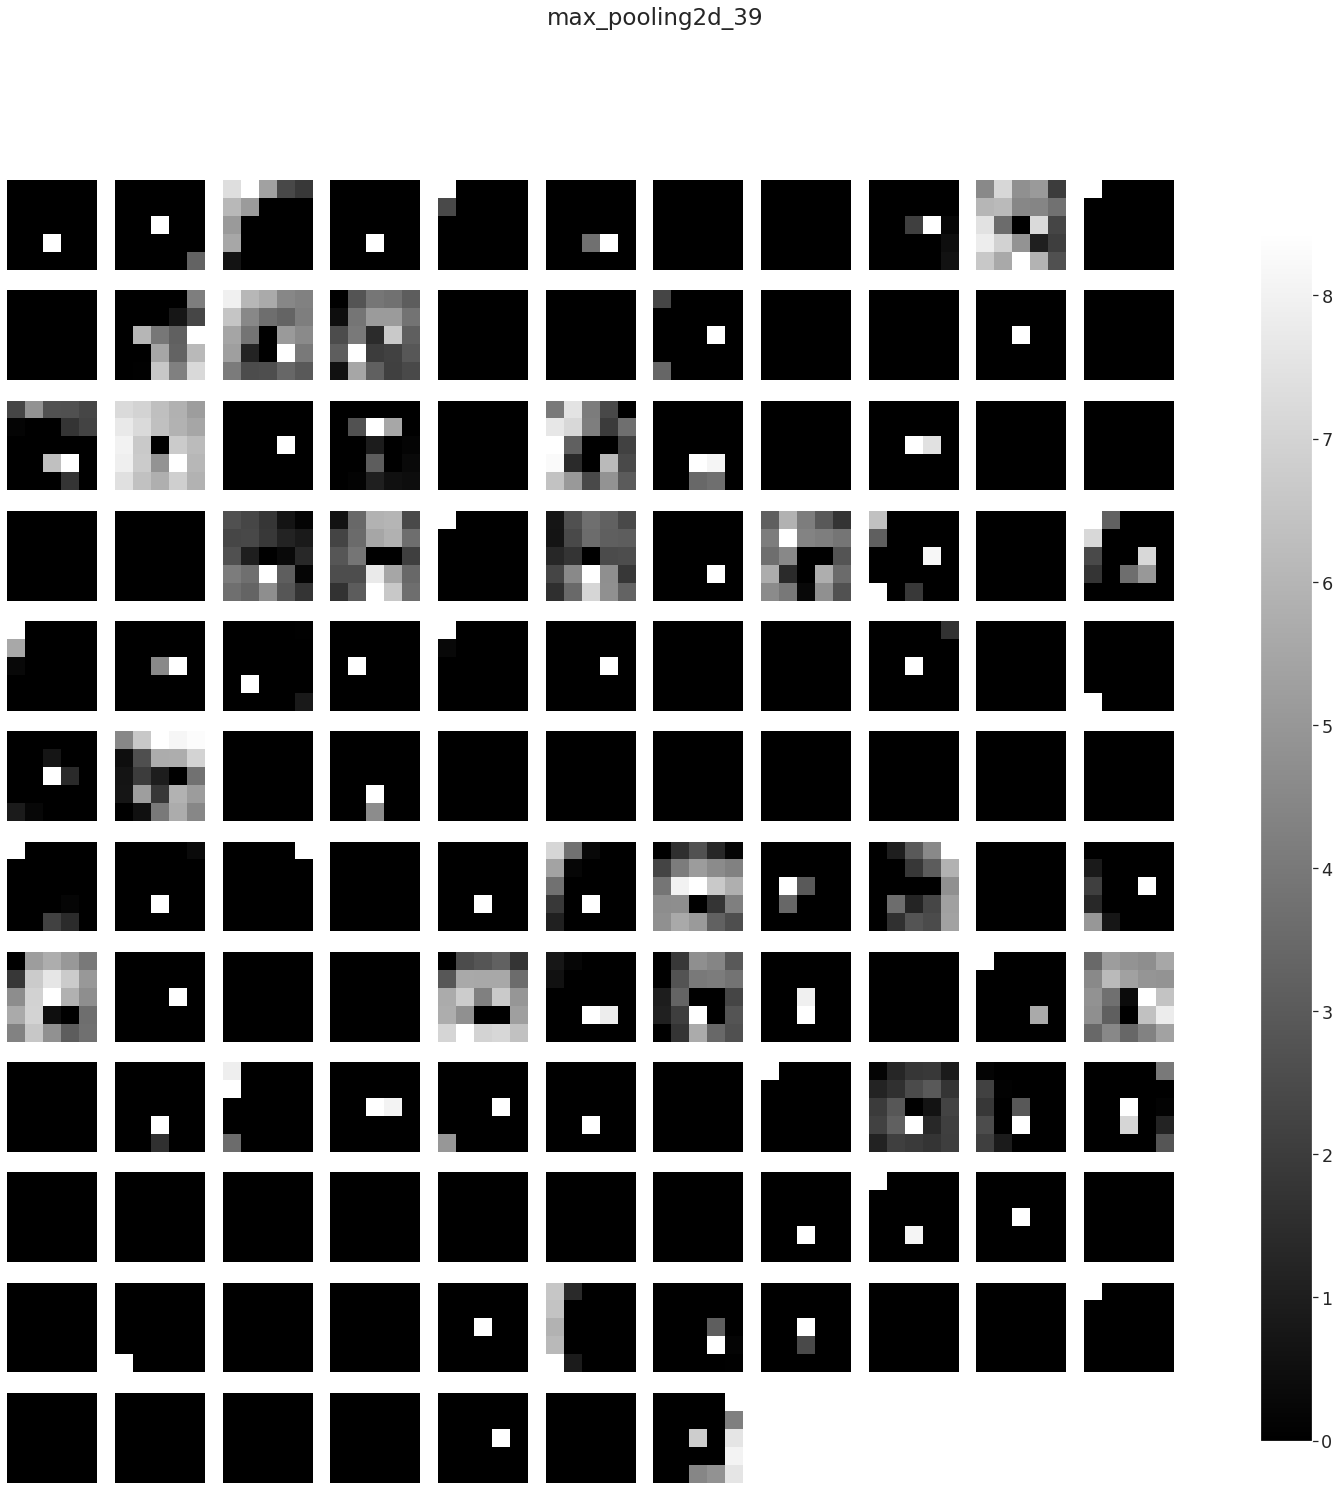

dropout_39 (1, 5, 5, 128) 


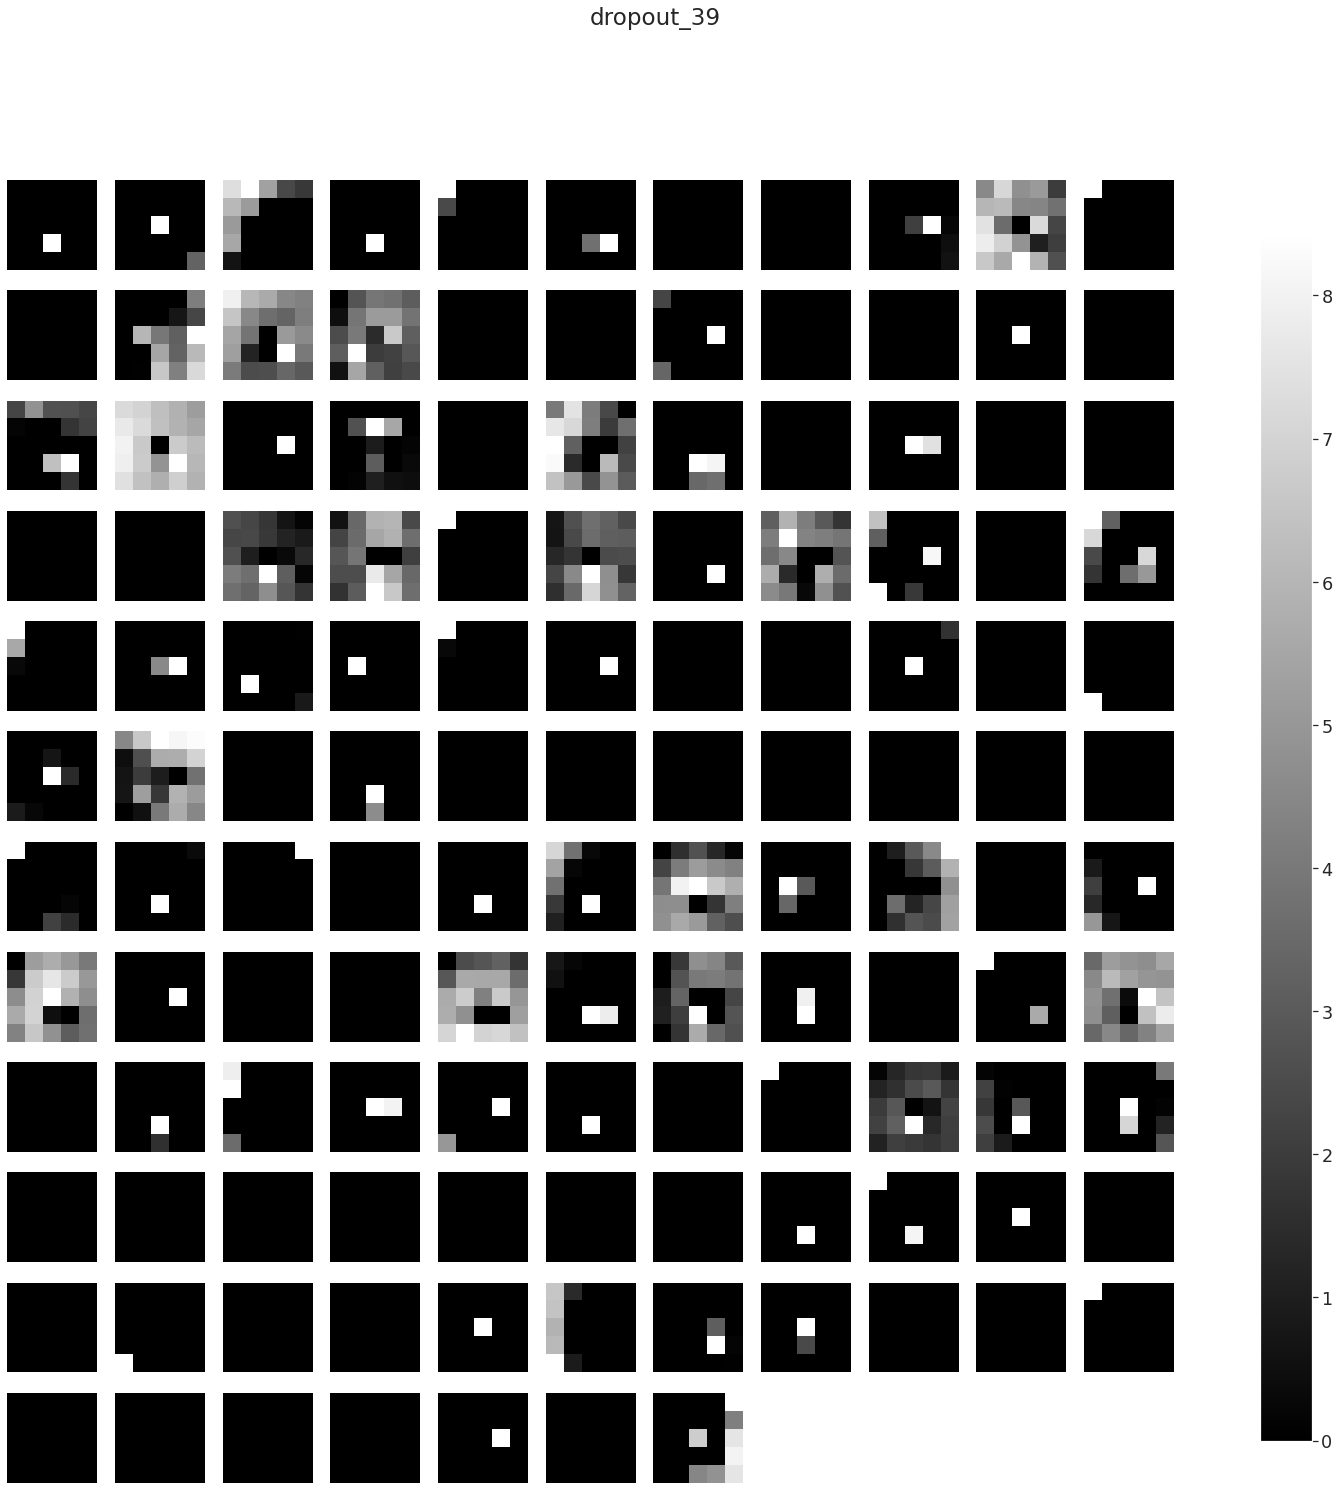

conv2d_73 (1, 3, 3, 64) 


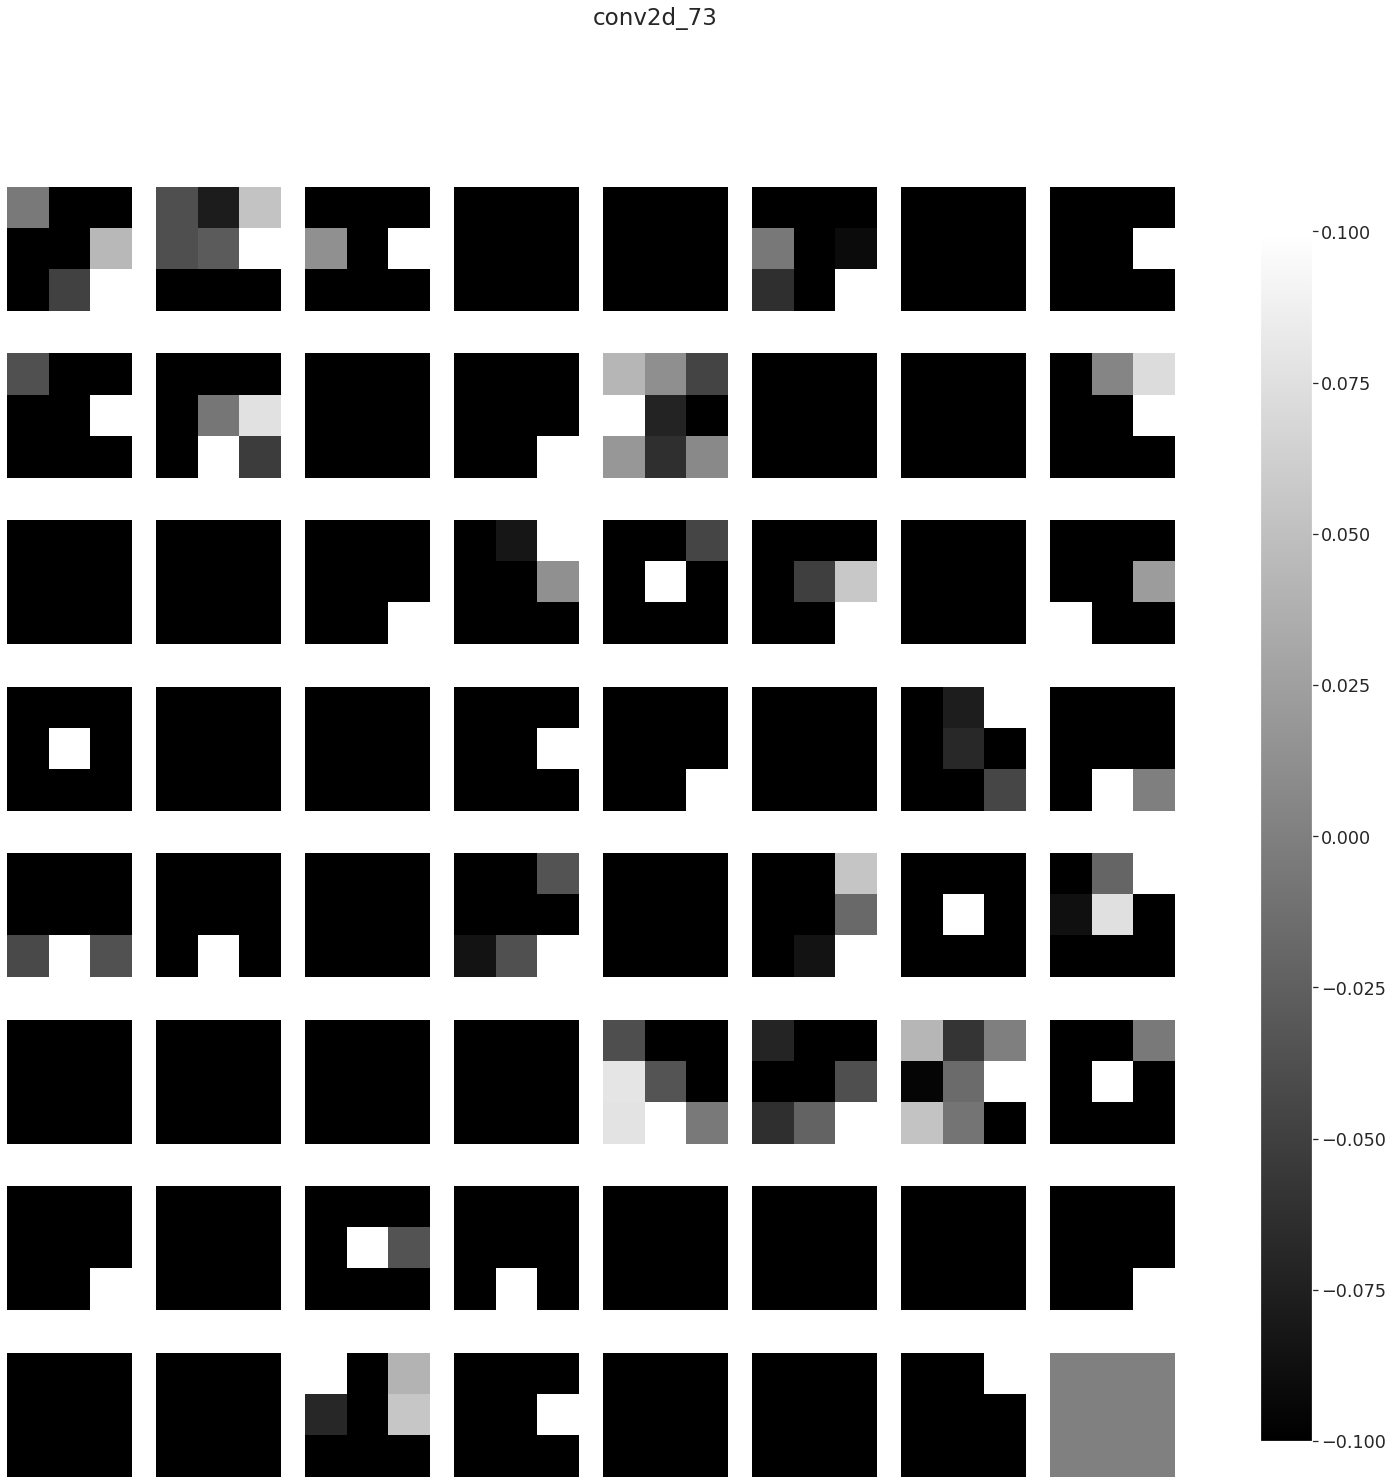

batch_normalization_17 (1, 3, 3, 64) 


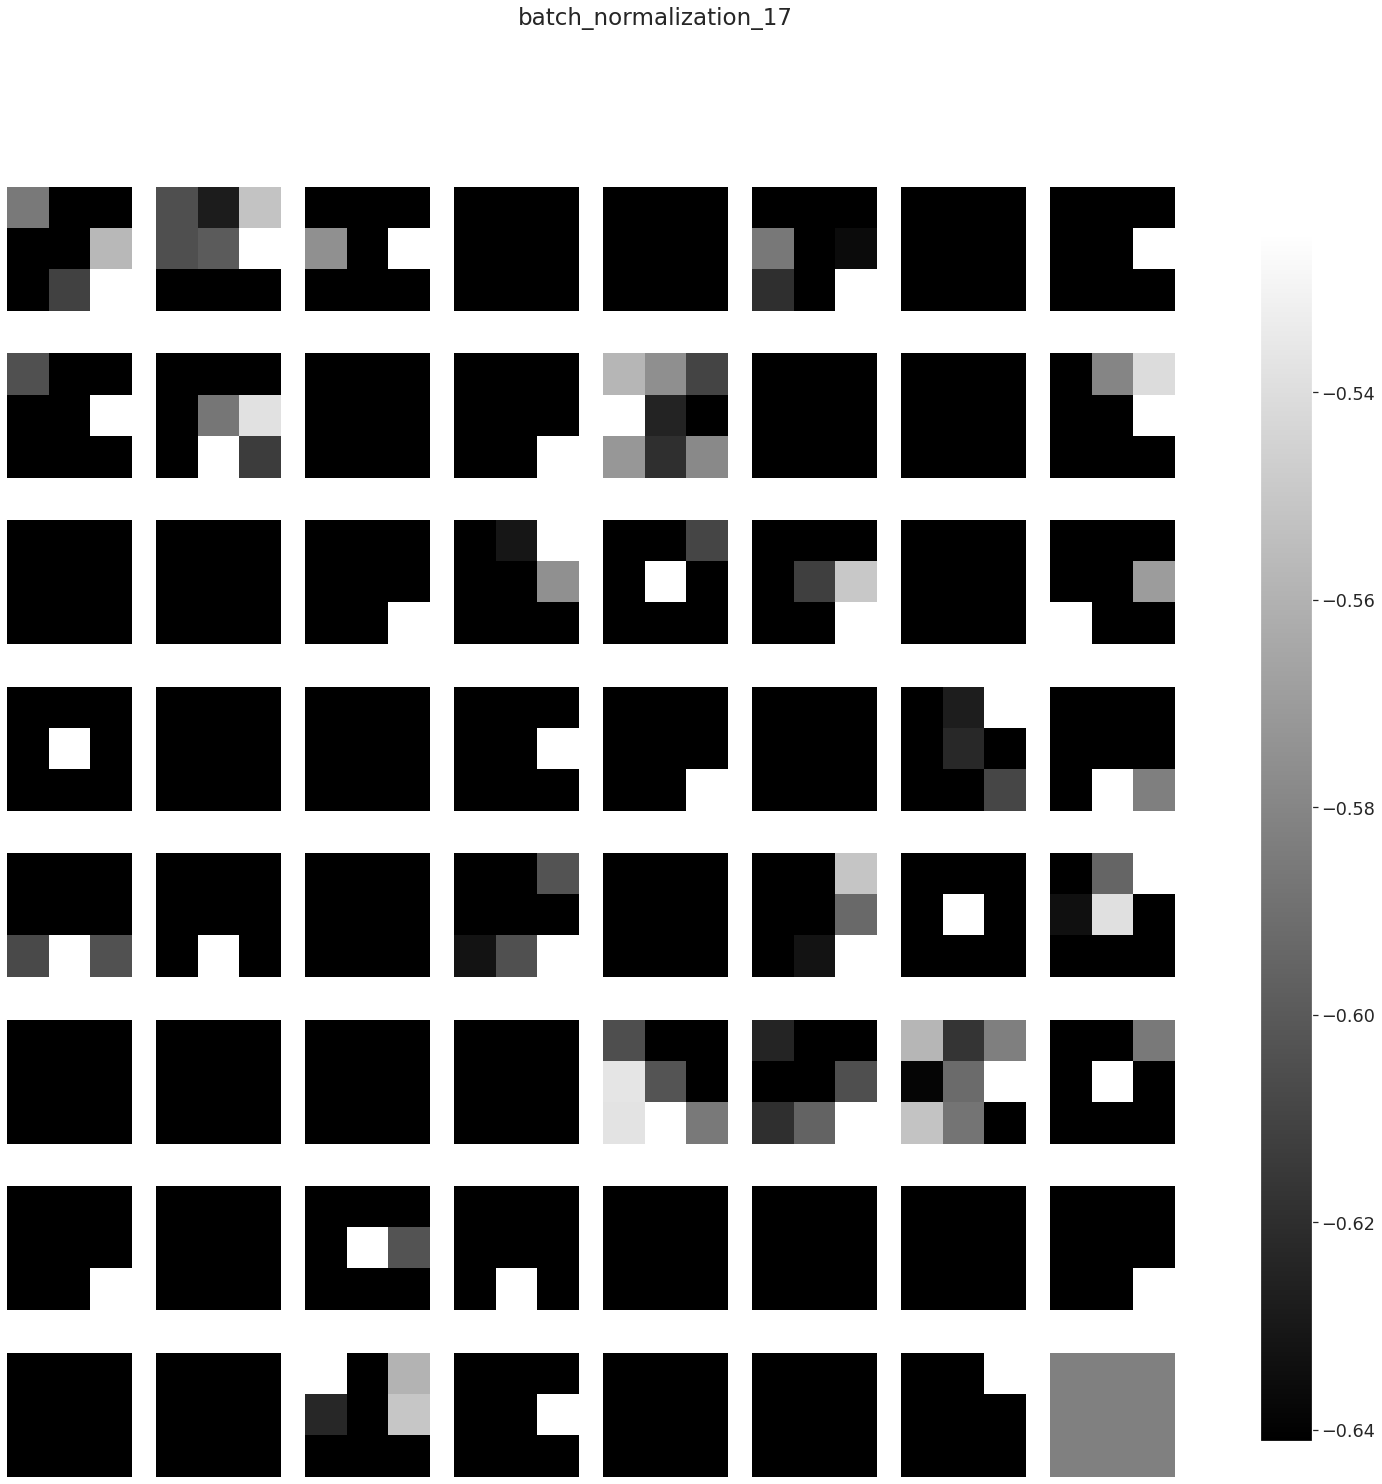

max_pooling2d_40 (1, 1, 1, 64) 


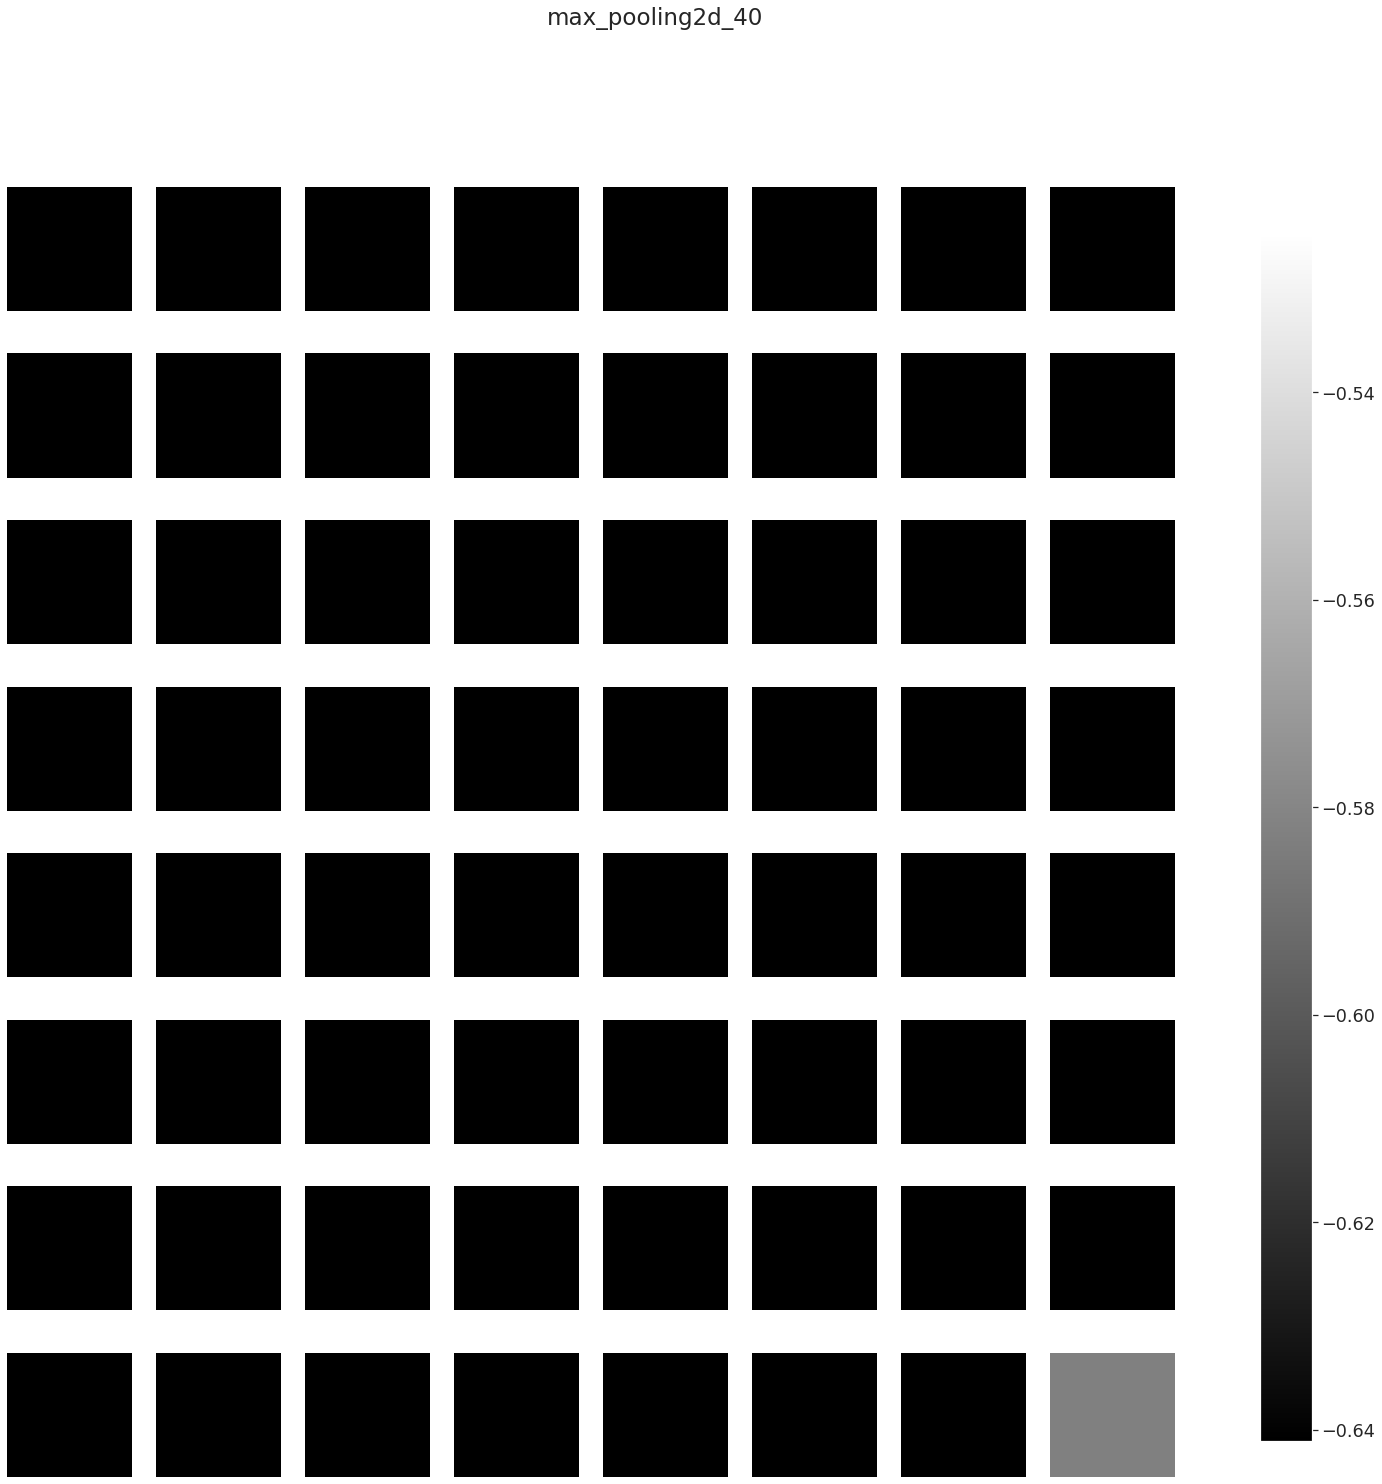

dropout_40 (1, 1, 1, 64) 


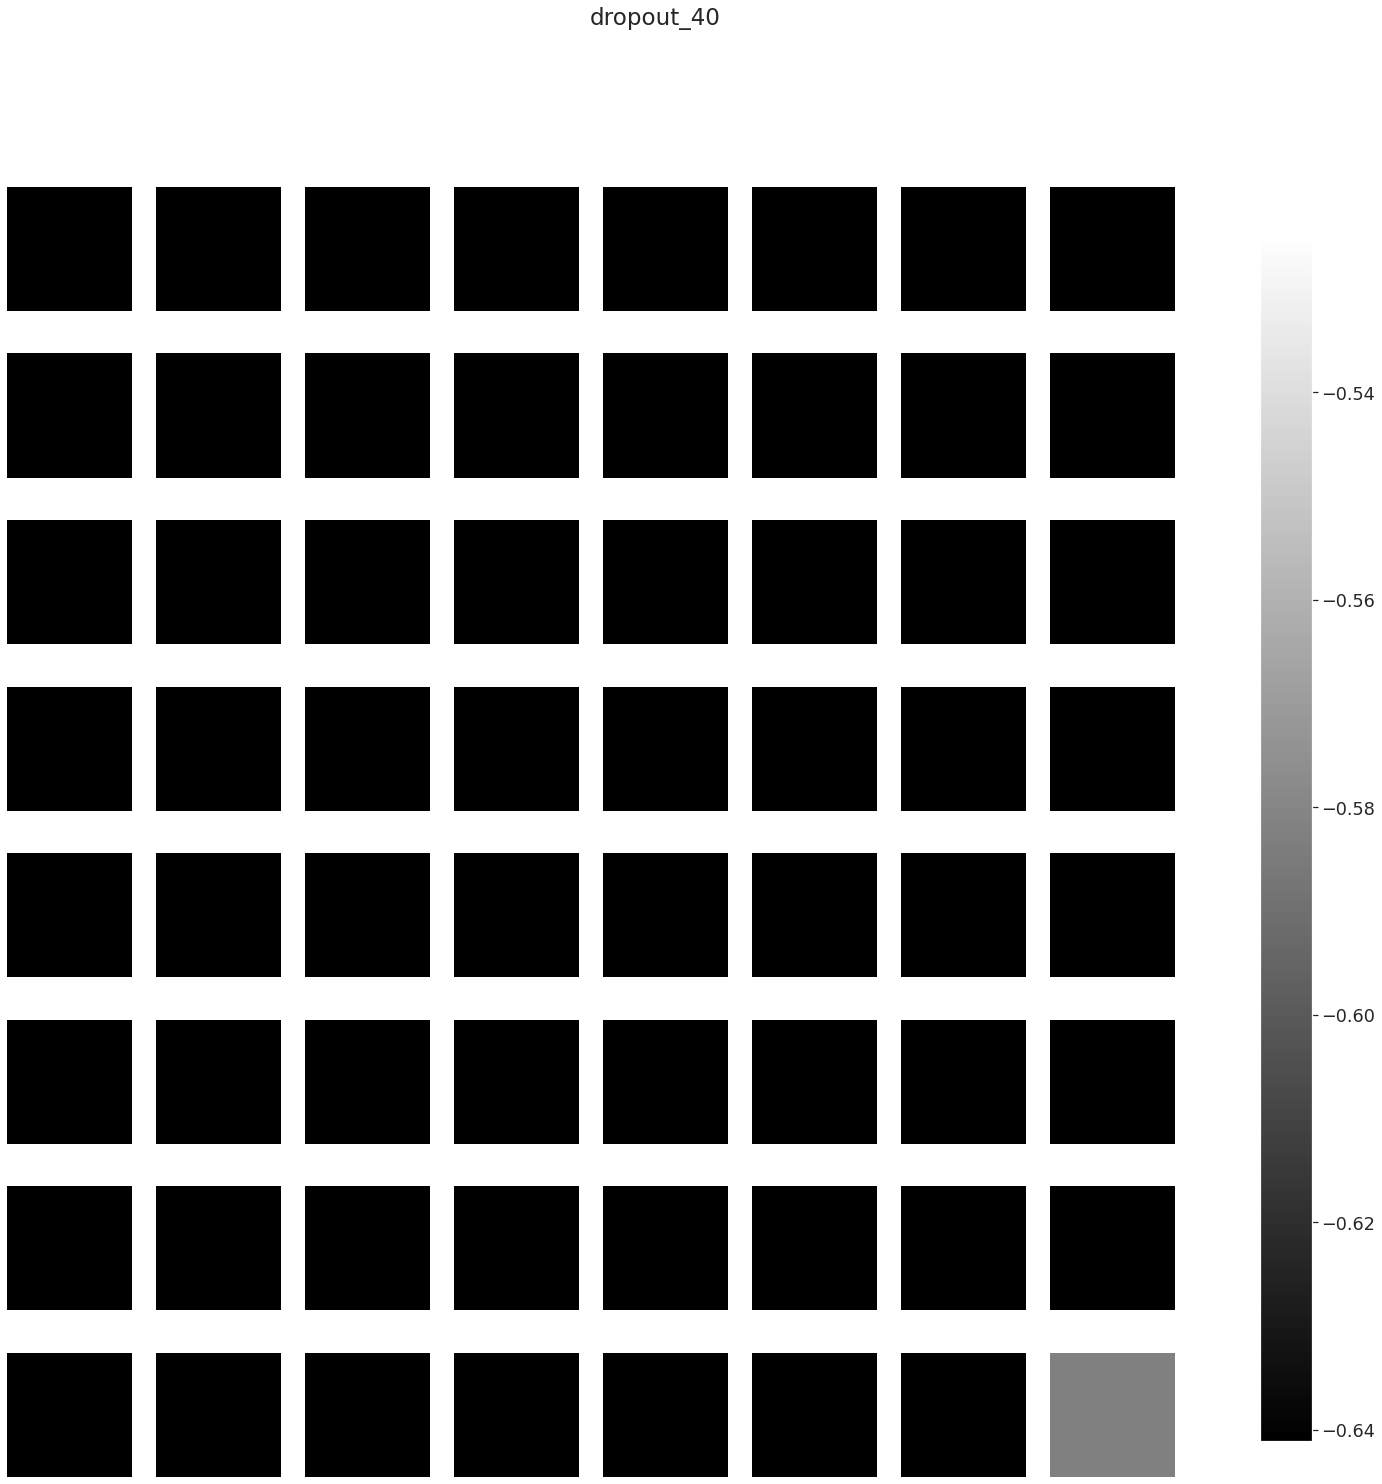

flatten_18 (1, 64) 


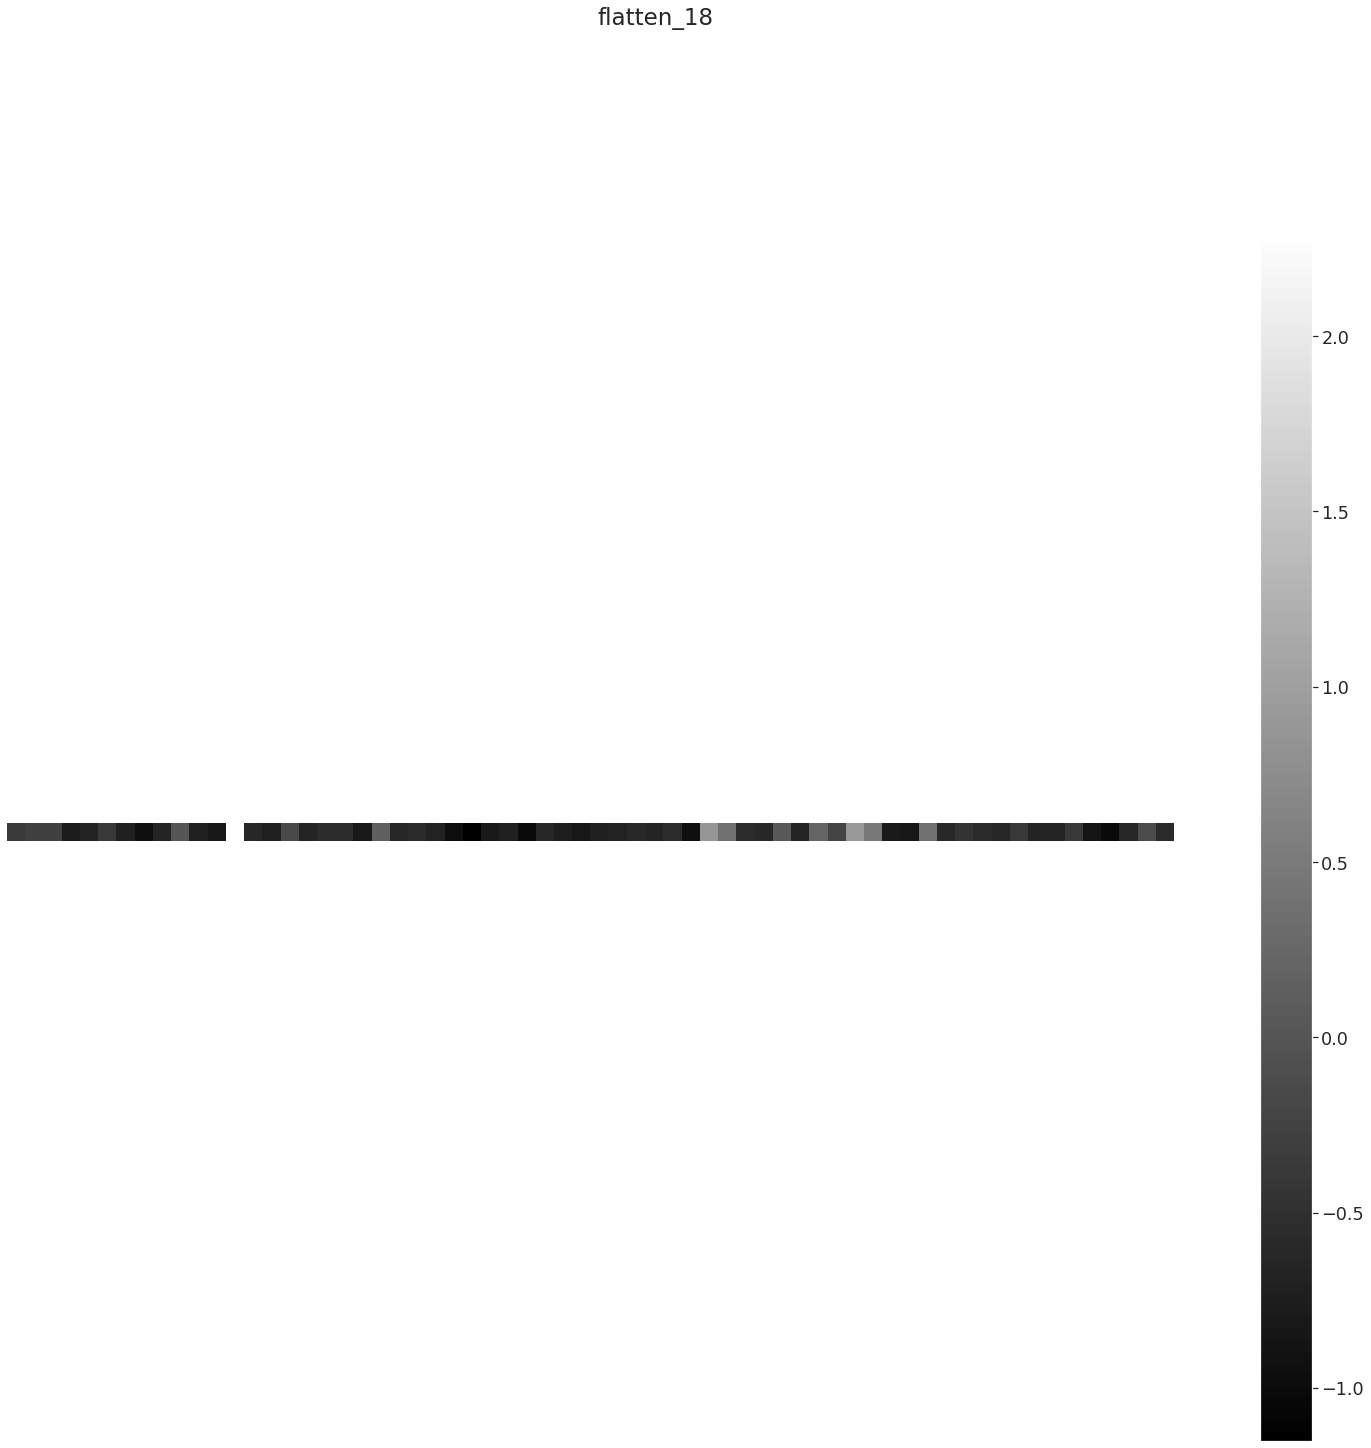

dense_52 (1, 64) 


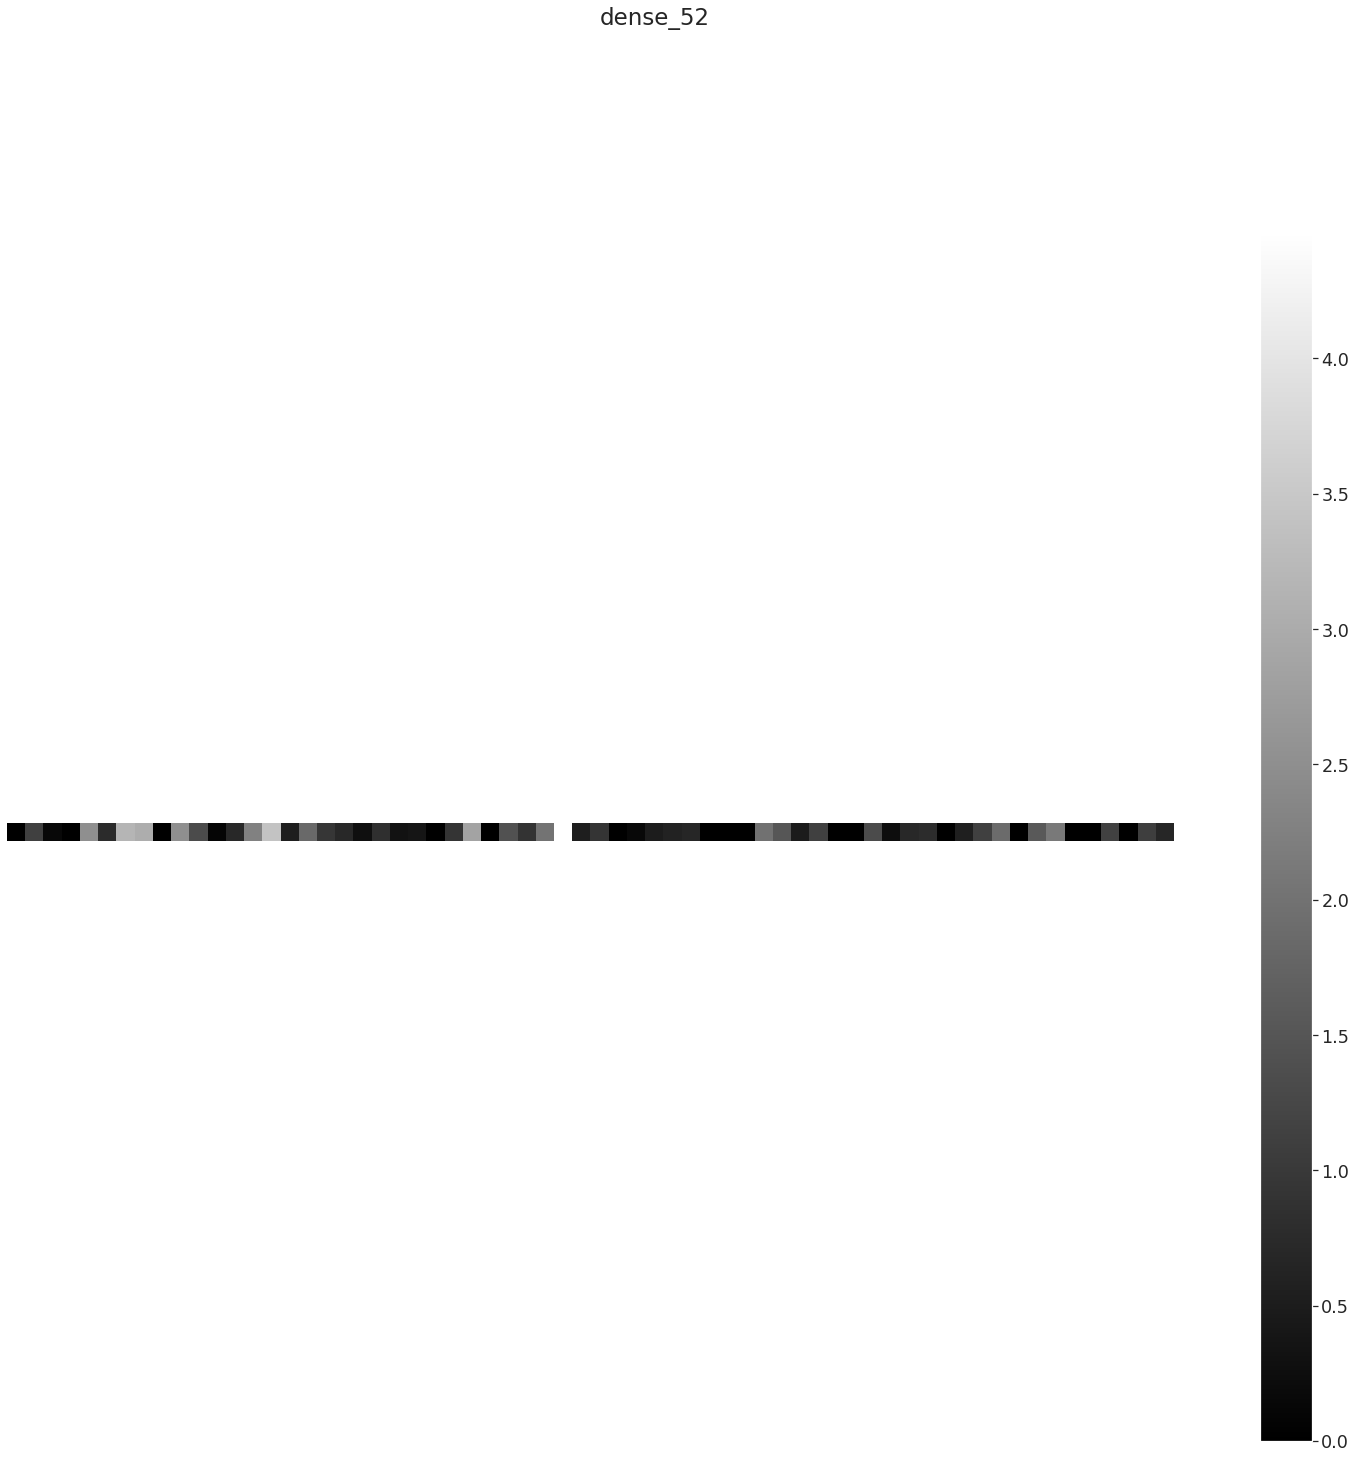

dense_53 (1, 32) 


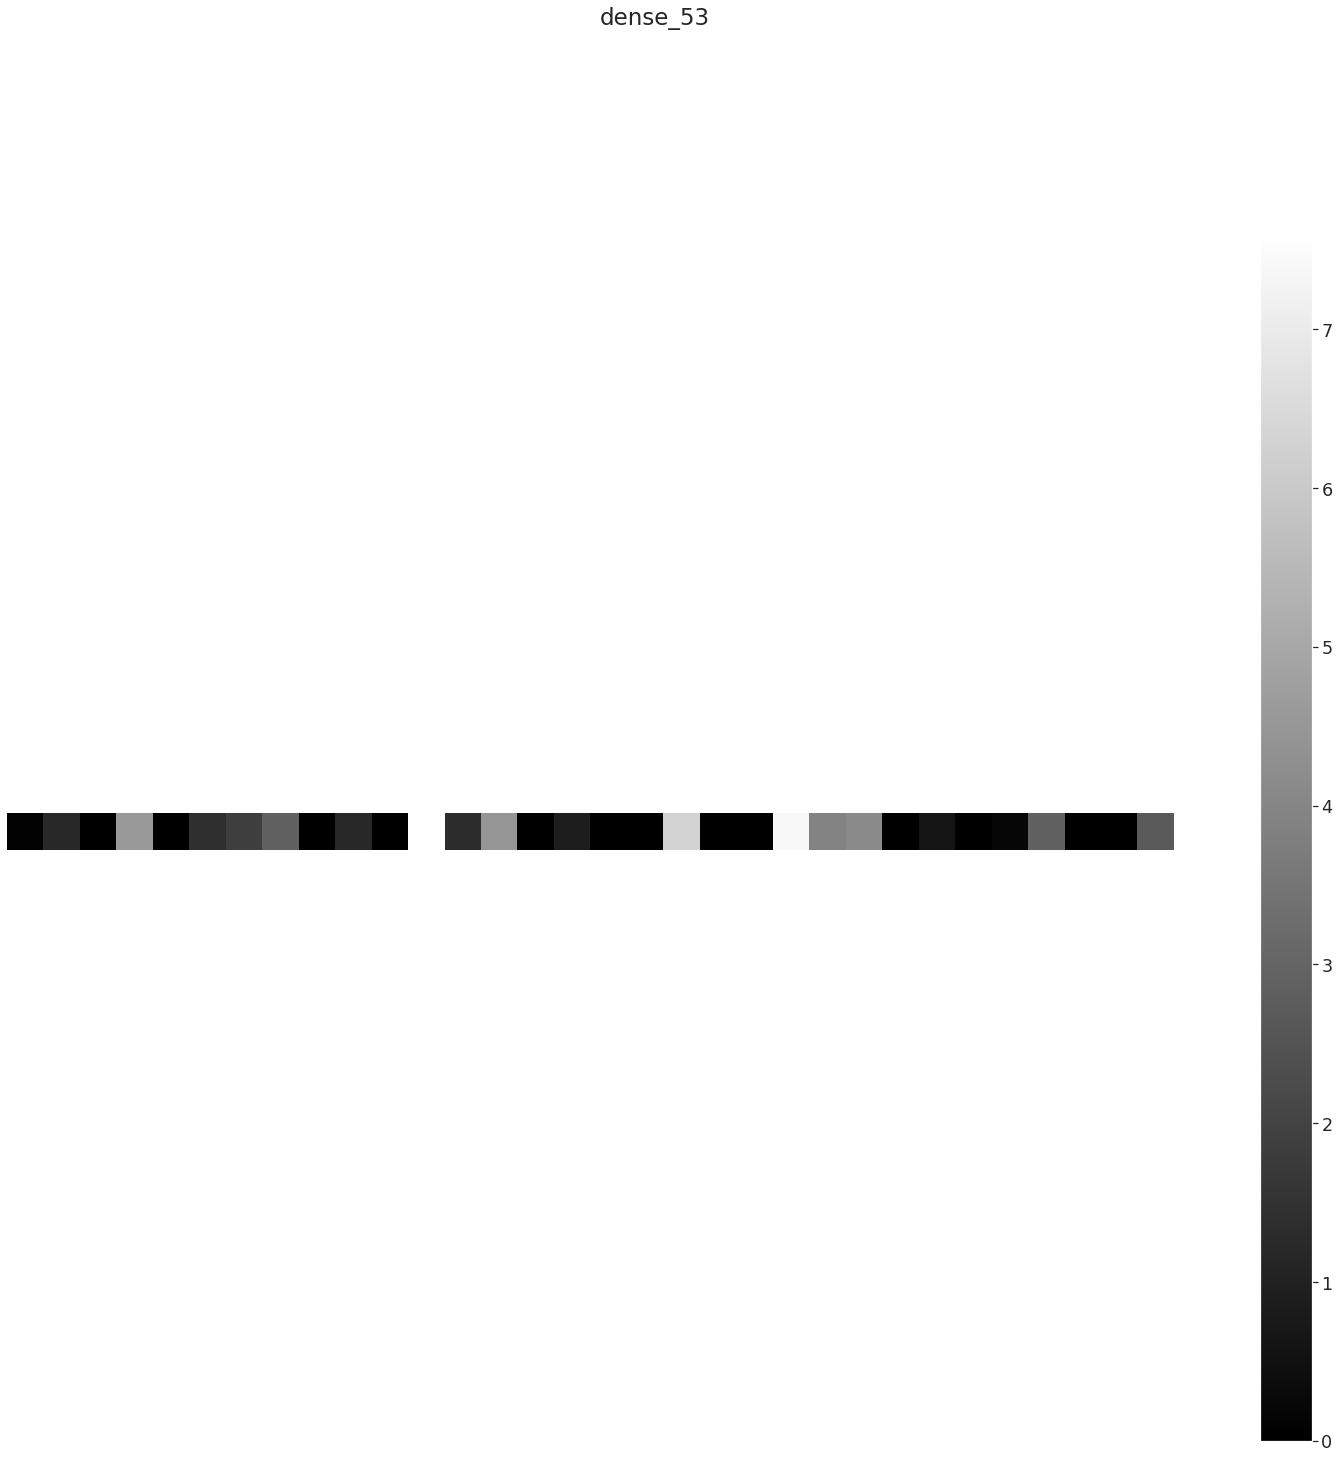

dense_54 (1, 7) 


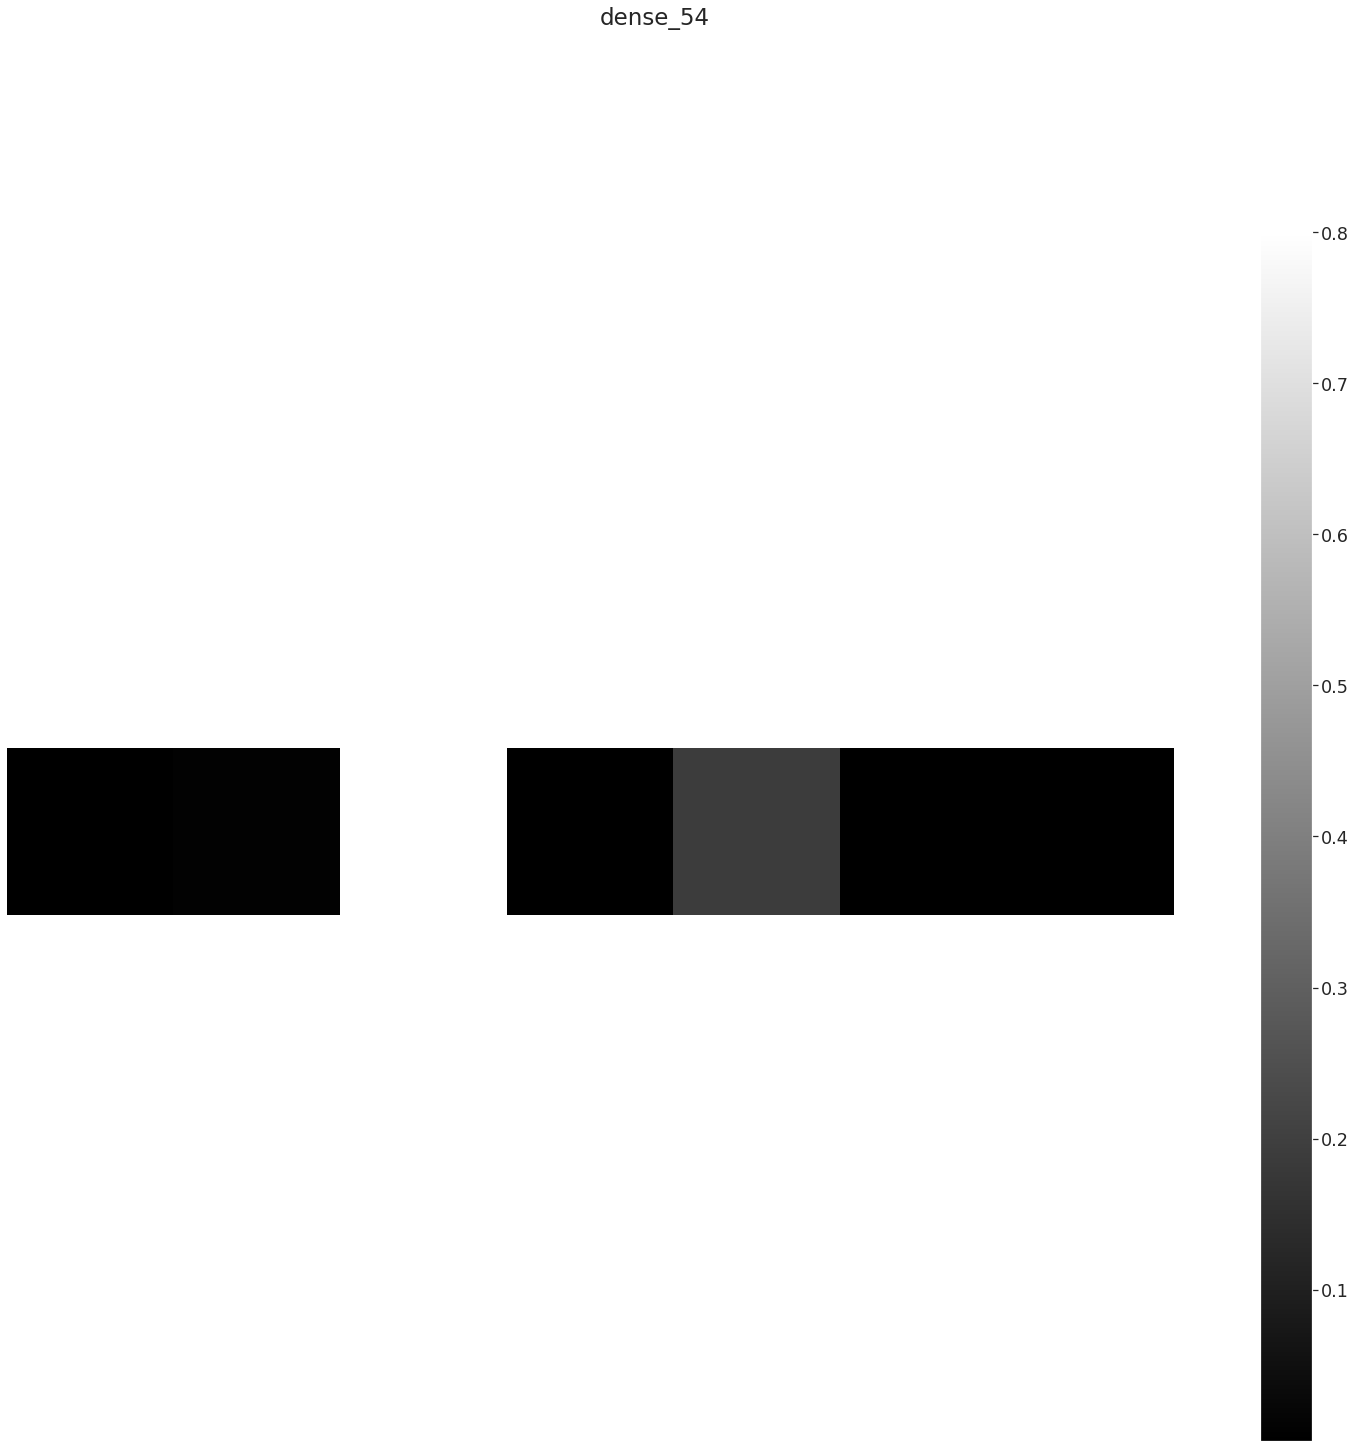

In [ ]:
# =============================================
# Keract visualizations
# =============================================
from keract import get_activations, display_activations
keract_inputs = x_test[:1]
keract_targets = y_test[:1]
activations = get_activations(model, keract_inputs)
display_activations(activations, cmap="gray", save=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


conv2d_71_input (1, 28, 28, 3) 


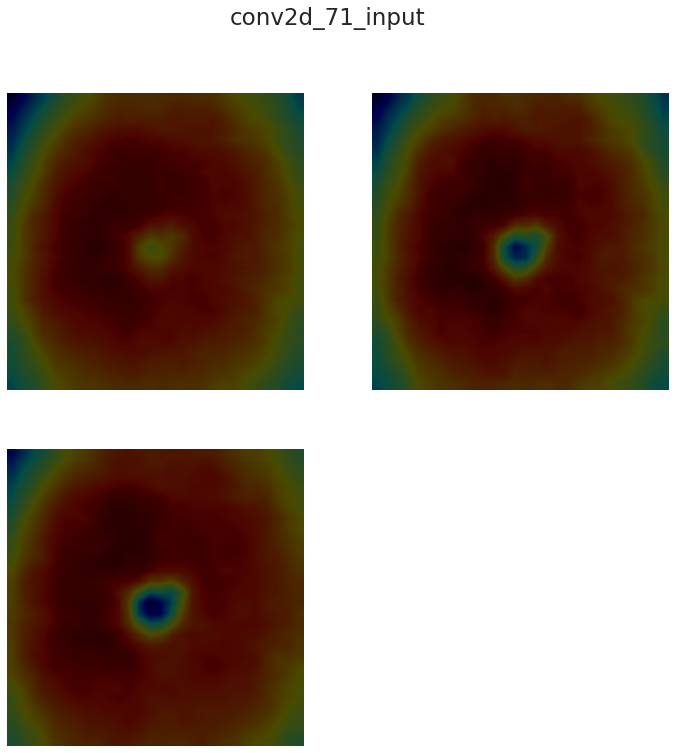

conv2d_71 (1, 26, 26, 256) 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

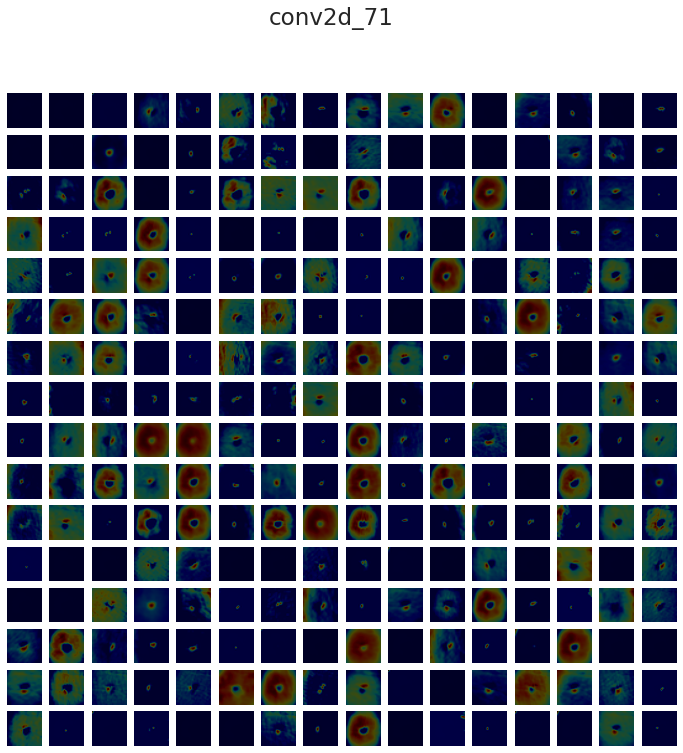

batch_normalization_16 (1, 26, 26, 256) 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

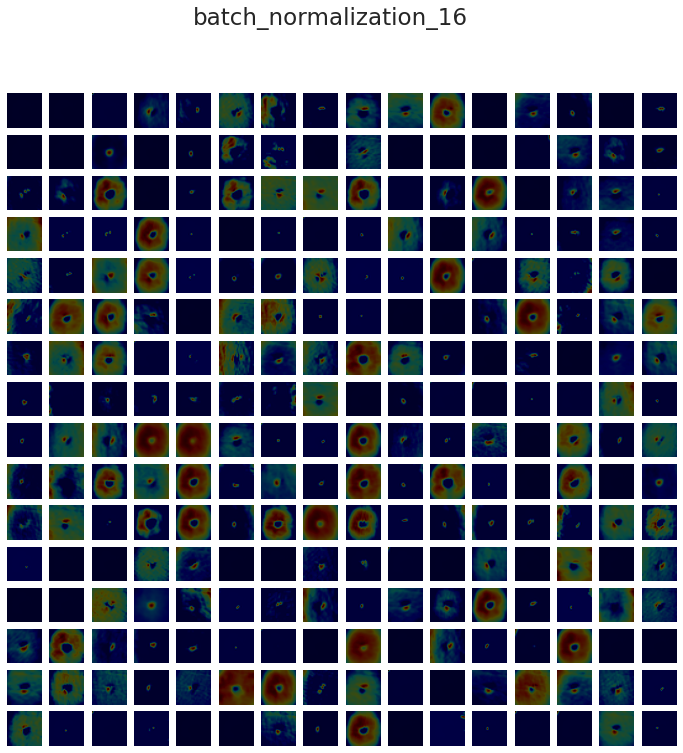

max_pooling2d_38 (1, 13, 13, 256) 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

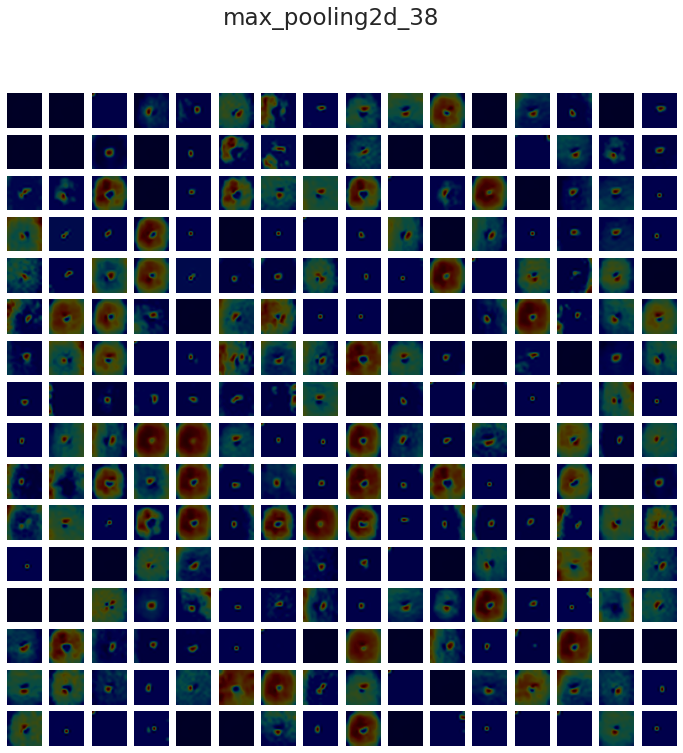

dropout_38 (1, 13, 13, 256) 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

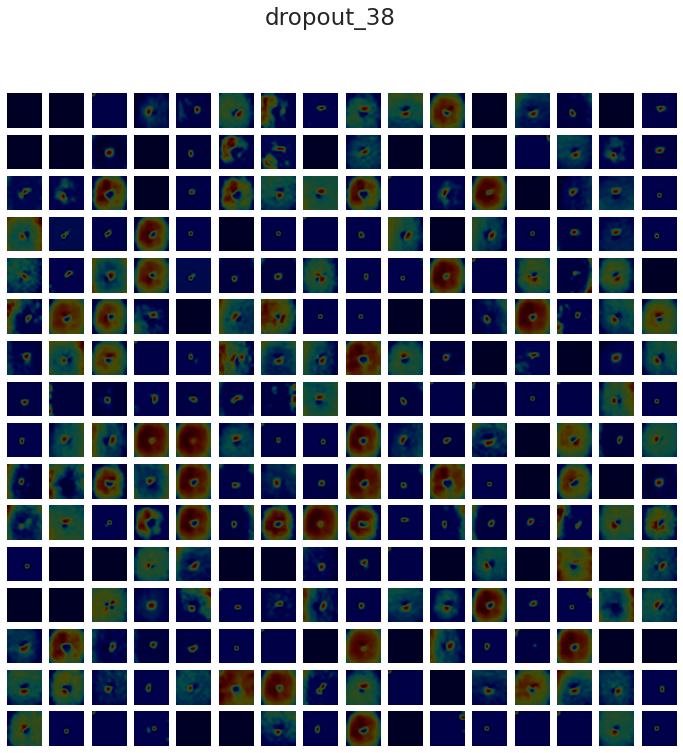

conv2d_72 (1, 11, 11, 128) 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

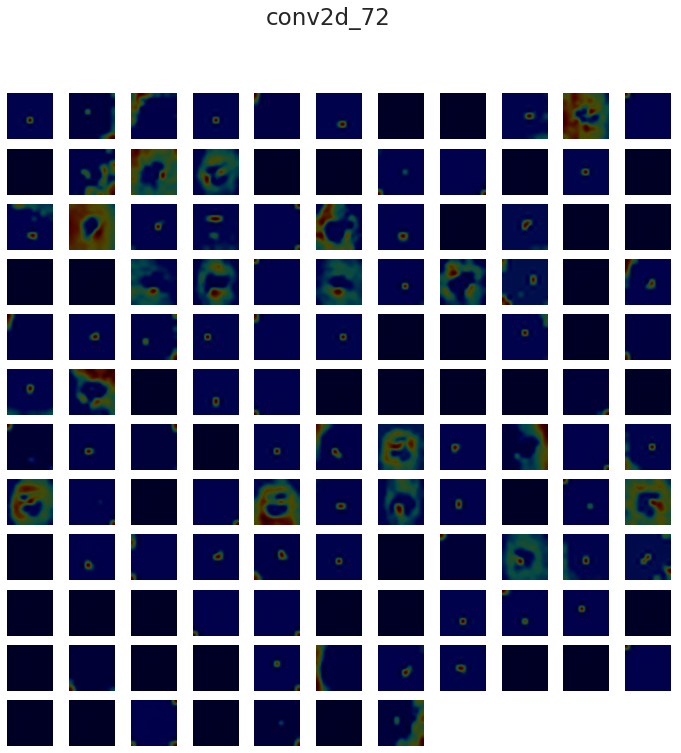

max_pooling2d_39 (1, 5, 5, 128) 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

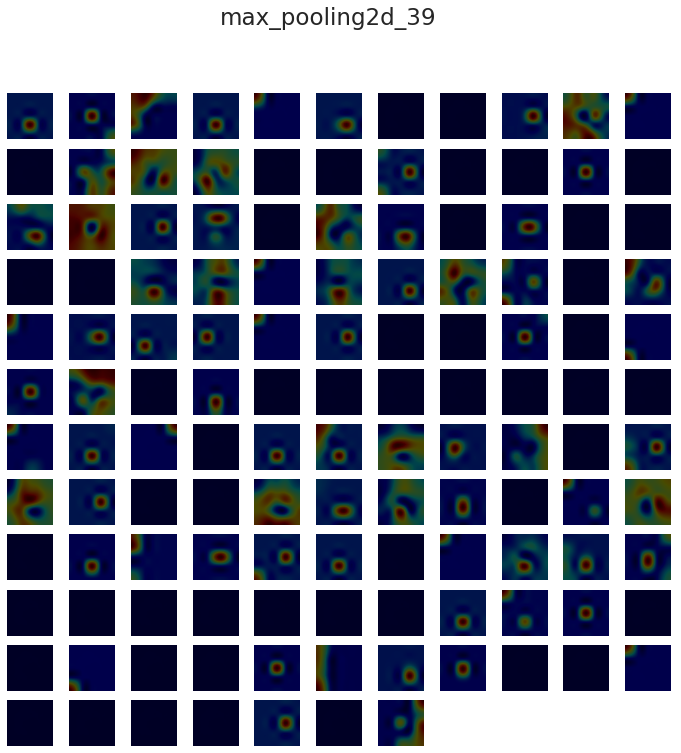

dropout_39 (1, 5, 5, 128) 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

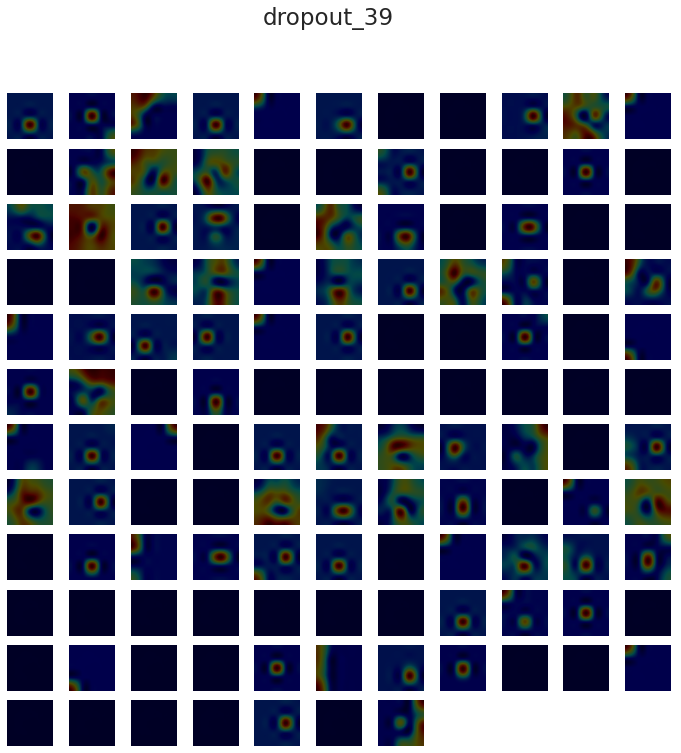

conv2d_73 (1, 3, 3, 64) 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

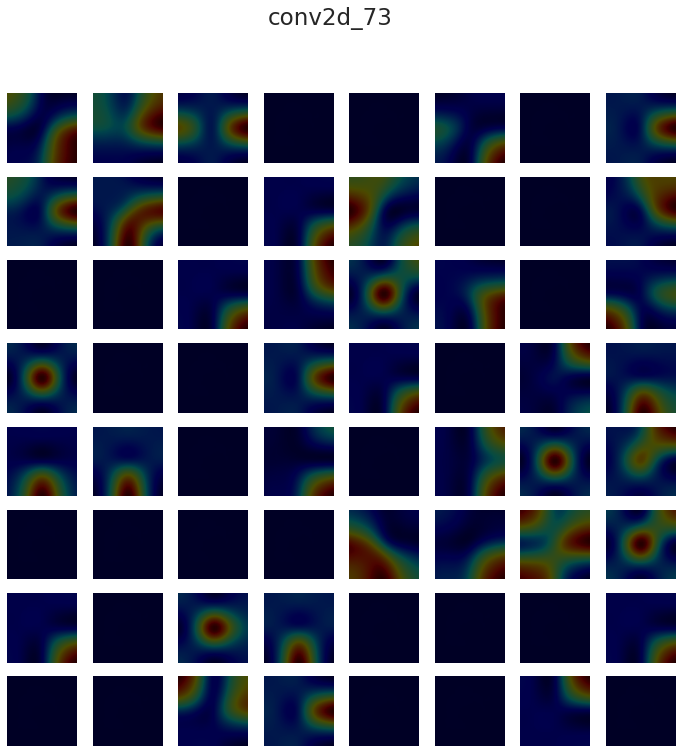

batch_normalization_17 (1, 3, 3, 64) 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

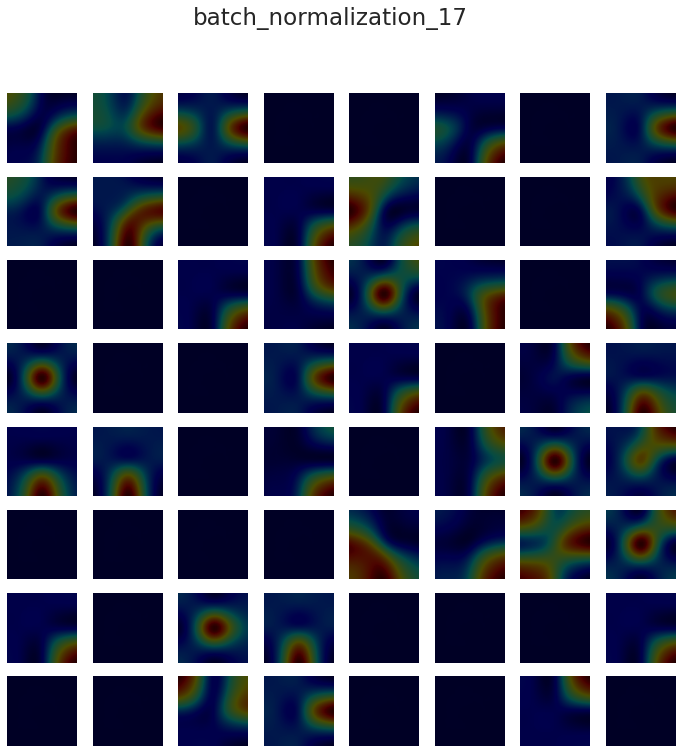

max_pooling2d_40 (1, 1, 1, 64) 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

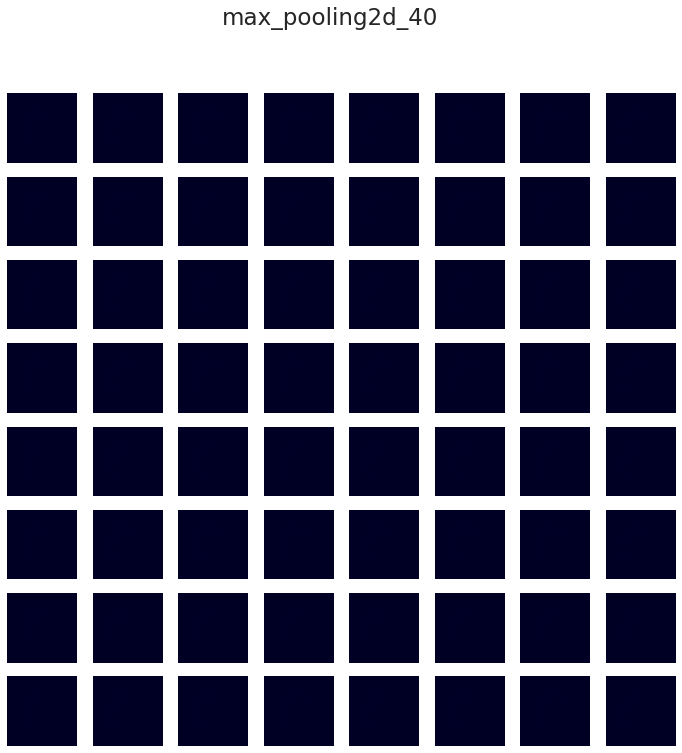

dropout_40 (1, 1, 1, 64) 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

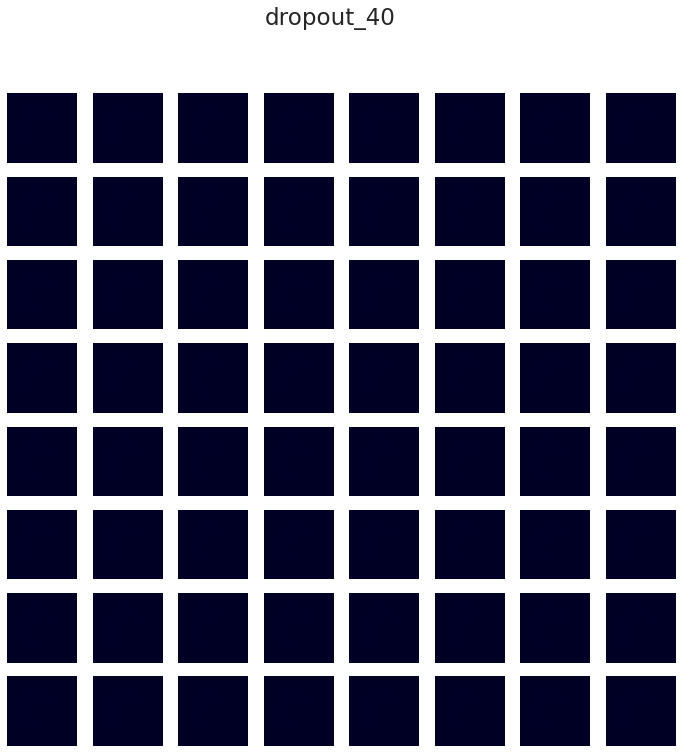

flatten_18 (1, 64) -> Skipped. 2D Activations.
dense_52 (1, 64) -> Skipped. 2D Activations.
dense_53 (1, 32) -> Skipped. 2D Activations.
dense_54 (1, 7) -> Skipped. 2D Activations.


In [ ]:
# =============================================
# Keract visualizations
# =============================================
from keract import get_activations, display_heatmaps
keract_inputs = x_test[:1]
keract_targets = y_test[:1]
activations = get_activations(model, keract_inputs)
display_heatmaps(activations, keract_inputs, save=False)

In [ ]:
x = x_test[:1, :28, :]
print(x.shape)
model.predict(x)

(1, 28, 28, 3)


array([[2.4850755e-10, 1.5237321e-08, 1.1629834e-06, 1.0124422e-06,
        9.9998975e-01, 8.3140828e-09, 8.0651098e-06]], dtype=float32)

#Implementar Aplicação WEB para prever novas imagens


In [ ]:
MODEL_PATH = '/content/drive/MyDrive/SkinCancer/model.h5'

In [ ]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.applications.imagenet_utils import preprocess_input, decode_predictions
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

# Some utilites
import numpy as np

In [ ]:
def get_model(MODEL_PATH):
    global model
    model = load_model(MODEL_PATH)
    print("Model loaded!")

In [ ]:
get_model()

Model loaded!


In [ ]:
#Carregando imagens
def load_image(img_path):
  img = image.load_img(img_path, target_size=(28, 28))
  img_tensor = image.img_to_array(img)                    
  img_tensor = np.array(img_tensor).reshape(-1,28,28,3)          #Reshape
  img_tensor = (img_tensor-np.mean(img_tensor))/np.std(img_tensor)      #Standerização                          

  return img_tensor

In [ ]:
import matplotlib.pyplot as plt

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


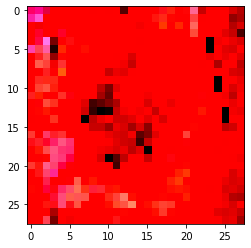

In [ ]:
teste = load_image('/content/drive/MyDrive/SkinCancer/reorganizado/bcc/ISIC_0024331.jpg')
plt.imshow(teste.reshape(28,28,3))

In [ ]:
labels_dict = {4: 'Melanocytic nevi',
    6: 'Melanoma',
    2: 'Benign keratosis-like lesions ',
    1: 'Basal cell carcinoma',
    0: 'Actinic keratoses',
    5: 'Vascular lesions',
    3: 'Dermatofibroma'}

In [ ]:
def prediction(img_path):
  new_img = load_image(img_path)

  pred = model.predict(new_img)[0]
  pred_classes = np.argmax(pred) #Retorna o indice com maior valor entre as 7 classes

  for k,v in labels_dict.items():
    if k == pred_classes:
      print('Tipo de lesão/câncer: ',v)
      print("Probabilidades: ",round((pred[k]*100),2),'%') #Retorna a probabilidade do index arrendondada

Os valores da função predict retorna a probabilidade para cada classe de acordo com a entrada


In [ ]:
prediction('/content/drive/MyDrive/SkinCancer/reorganizado/bcc/ISIC_0024331.jpg')

Tipo de lesão/câncer:  Basal cell carcinoma
Probabilidades:  99.97 %


#A aplicação flask estara na pasta /app
